#Standard Imports and Google drive setup

In [ ]:
NAME = "Santosh Aditya Yarlagadda"

In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [ ]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/MyDrive/stock_prediction"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
else:
    raise RuntimeError("This notebook should be run from Colab, not on the local machine")

Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/MyDrive/stock_prediction  exists.

Colab: Changing directory to  /content/gdrive/MyDrive/stock_prediction
/content/gdrive/MyDrive/stock_prediction


In [ ]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import math
%matplotlib inline
import seaborn as sns
## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )


Running TensorFlow version  2.6.0
Version 2, minor 6


In [ ]:
pip install nose

     |████████████████████████████████| 154 kB 5.3 MB/s 


In [ ]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helperv1
import helperv2
%aimport helperv1
%aimport helperv2

helperv1 = helperv1.HELPER()
helperv2 = helperv2.Helper()



#Functions
- We store the definitions of cutom functions created for this notebook in this section

In [ ]:
#function to plot model loss
def plotTrain(history, model_name="???"):
    plt.figure(figsize=(7.5, 5) )
  
    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(model_name + " " + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()

#function to plot Residuals
def plot_residual(y_test,y_test_pred):
    plt.figure(figsize=(7.5, 5))
    y_test_df = pd.DataFrame(y_test)
    y_test_pred_df = pd.DataFrame(y_test_pred)
    Residual = y_test_df - y_test_pred_df
    plt.scatter(y=Residual, x=y_test_df.index)

    plt.title("Residual Plot")
    plt.ylabel('Residual')
    plt.xlabel('Time step')
    plt.grid()

#Getting the data
- Here we import the AAPL csv file for our stock predictions
- We would also want to import all the other files (different stock prices) in the data folder as master df for future use

In [ ]:
tickers = ["AAPL","ACN","SPY","ADBE","CRM","CSCO","FB","GOOG","IBM","INTC","MA","MSFT","NVDA","V","XLB","XLE","XLF","XLI","XLK","XLP","XLRE","XLU","XLV","XLY"]
dateAttr = "Dt" #index column
priceAttr = ["Dt","Adj Close","Div","Volume","High","Low","Open"]

# Read the CSV files
data_master = []
for ticker_num, ticker in enumerate(tickers):
    ticker_file = os.path.join("./Data/train", "{t}.csv".format(t=ticker) )
    ticker_df = pd.read_csv(ticker_file,index_col=0,usecols=priceAttr) 
    # Rename attributes with ticker name
    ticker_df["Return"]  = ticker_df["Adj Close"].pct_change() 
    rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in ticker_df.columns.to_list() }     
    ticker_df= ticker_df.rename(columns=rename_map) 
    data_master.append(ticker_df)     
data_master = pd.concat(data_master,axis=1)


In [ ]:
#dimensions of data
print("Dimensions of the master data set:")
print("No. of examples",data_master.shape[0])
print("No. of features",data_master.shape[1])

#Date Range
print("Data Range of the master data set:")
print("Start : ",min(data_master.index))
print("End : ",max(data_master.index))


Dimensions of the master data set:
No. of examples 4277
No. of features 168
Data Range of the master data set:
Start :  2000-01-03
End :  2016-12-30


**Let's check for missing values**

Text(0.5, 14.09375, 'Columns')

Text(33.0, 0.5, 'Date')

Text(0.5, 1.0, 'Missing Value visualization')

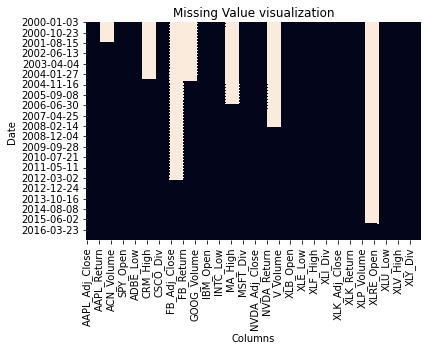

In [ ]:
sns.heatmap(data_master.isnull(), cbar=False)
plt.xlabel("Columns")
plt.ylabel("Date")
plt.title("Missing Value visualization")

- The above graph visualizes the missing values in our data set
- We can clearly see that some of the features have missing values. And these missing values are continous, i.e., there is data available for only a fixed date range
- For example FB, GOOG, MA have lesser data as they were listed after AAPL
- Also our data set starts from the year 2000. Some of the early data might not be useful for predicting the returns in the later stages
- XLRE has only 311 price points. So we remove this feature for our analysis

**Now lets look at FB date range**

In [ ]:
df_FB = data_master.loc[:,"FB_Adj_Close":"FB_Return"]
df_FB = df_FB[df_FB.notnull().all(1)]

#Dates for which FB data is available
print("Data Range of the FB data set:")
print("No. of examples",min(df_FB.index))
print("No. of features",max(df_FB.index))

df_FB.head()

Data Range of the FB data set:
No. of examples 2012-05-21
No. of features 2016-12-30


,FB_Adj_Close,FB_Div,FB_High,FB_Low,FB_Open,FB_Volume,FB_Return
Dt,,,,,,,
2012-05-21,34.03,0.0,36.66,33.00,36.53,168192700.0,-0.109861
2012-05-22,31.00,0.0,33.59,30.94,32.61,101786600.0,-0.089039
2012-05-23,32.00,0.0,32.50,31.36,31.37,73600000.0,0.032258
2012-05-24,33.03,0.0,33.21,31.77,32.95,50237200.0,0.032188
2012-05-25,31.91,0.0,32.95,31.11,32.90,37149800.0,-0.033909


- As we can see the data is only available from 2012-05-18. Considering return values dont have the first value our usable data starts from 2012-05-21
- We can use this date range for our total dataset. But in that case we loose valuable data for training


#Exploratory Data Analysis
- Now lets remove the features with missing values and plot the APPL_Retrun (target) with other stock returns
- This will give us an idea on the nature of the relationship between our features and target. Hopefully it will help us in identifying useful features

## Visualization using individual scatter plots

In [ ]:
#selecting return columns
data_pairplot = data_master[data_master.columns[data_master.columns.str.contains("Return")]]
#removing the features with missing data
drop_columns = ["FB_Return","V_Return","GOOG_Return","MA_Return","XLRE_Return","CRM_Return","ACN_Return"]
#dropping the features with missing values
data_pairplot = data_pairplot.drop(drop_columns,axis=1)
data_pairplot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AAPL_Return  4276 non-null   float64
 1   SPY_Return   4276 non-null   float64
 2   ADBE_Return  4276 non-null   float64
 3   CSCO_Return  4276 non-null   float64
 4   IBM_Return   4276 non-null   float64
 5   INTC_Return  4276 non-null   float64
 6   MSFT_Return  4276 non-null   float64
 7   NVDA_Return  4276 non-null   float64
 8   XLB_Return   4276 non-null   float64
 9   XLE_Return   4276 non-null   float64
 10  XLF_Return   4276 non-null   float64
 11  XLI_Return   4276 non-null   float64
 12  XLK_Return   4276 non-null   float64
 13  XLP_Return   4276 non-null   float64
 14  XLU_Return   4276 non-null   float64
 15  XLV_Return   4276 non-null   float64
 16  XLY_Return   4276 non-null   float64
dtypes: float64(17)
memory usage: 601.5+ KB


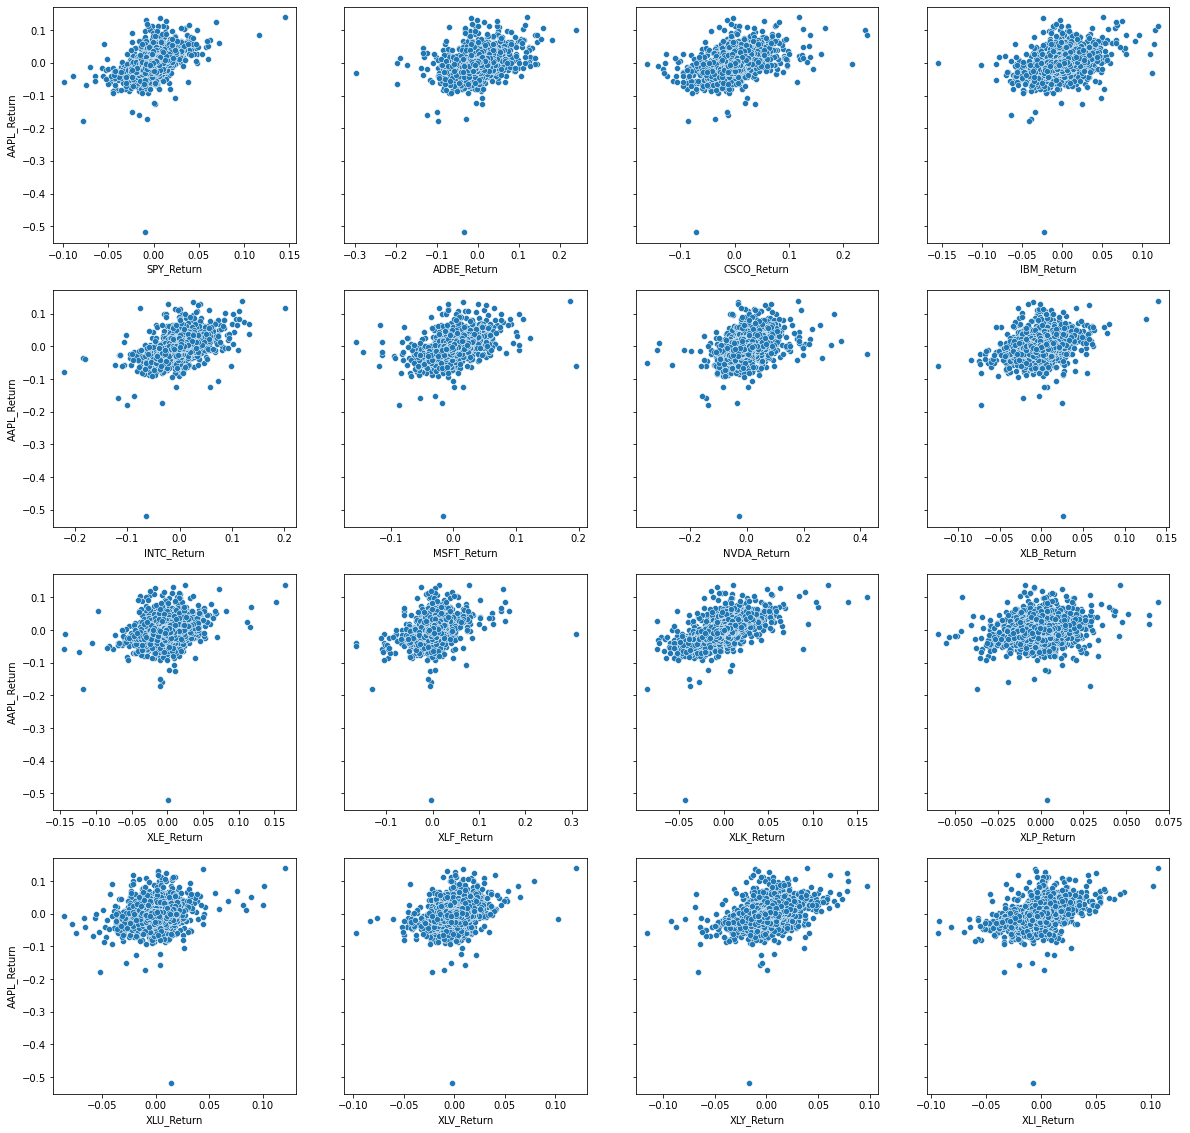

In [ ]:
fig, axes = plt.subplots(4,4,figsize=(20,20),sharey=True)
sns.set(style="ticks", color_codes=True)

sns.scatterplot(ax= axes[0,0], y=data_pairplot["AAPL_Return"],x=data_pairplot["SPY_Return"]);
sns.scatterplot(ax= axes[0,1], y=data_pairplot["AAPL_Return"],x=data_pairplot["ADBE_Return"]);
sns.scatterplot(ax= axes[0,2], y=data_pairplot["AAPL_Return"],x=data_pairplot["CSCO_Return"]);
sns.scatterplot(ax= axes[0,3], y=data_pairplot["AAPL_Return"],x=data_pairplot["IBM_Return"]);
sns.scatterplot(ax= axes[1,0], y=data_pairplot["AAPL_Return"],x=data_pairplot["INTC_Return"]);
sns.scatterplot(ax= axes[1,1], y=data_pairplot["AAPL_Return"],x=data_pairplot["MSFT_Return"]);
sns.scatterplot(ax= axes[1,2], y=data_pairplot["AAPL_Return"],x=data_pairplot["NVDA_Return"]);
sns.scatterplot(ax= axes[1,3], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLB_Return"]);
sns.scatterplot(ax= axes[2,0], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLE_Return"]);
sns.scatterplot(ax= axes[2,1], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLF_Return"]);
sns.scatterplot(ax= axes[2,2], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLK_Return"]);
sns.scatterplot(ax= axes[2,3], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLP_Return"]);
sns.scatterplot(ax= axes[3,0], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLU_Return"]);
sns.scatterplot(ax= axes[3,1], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLV_Return"]);
sns.scatterplot(ax= axes[3,2], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLY_Return"]);
sns.scatterplot(ax= axes[3,3], y=data_pairplot["AAPL_Return"],x=data_pairplot["XLI_Return"]);

plt.show()

- The above plots give us an insight into the relationship between AAPL returns with other stock returns
- Looking at the visualization, we can see that some of the features like SPY_Return, XLK_Return, XLI_Return show a linear relation
- Relationship with features like XLU_Return, XLF_Return seem to be random from the graph

**Now let's look at the relationship with the features that are missing intial data**

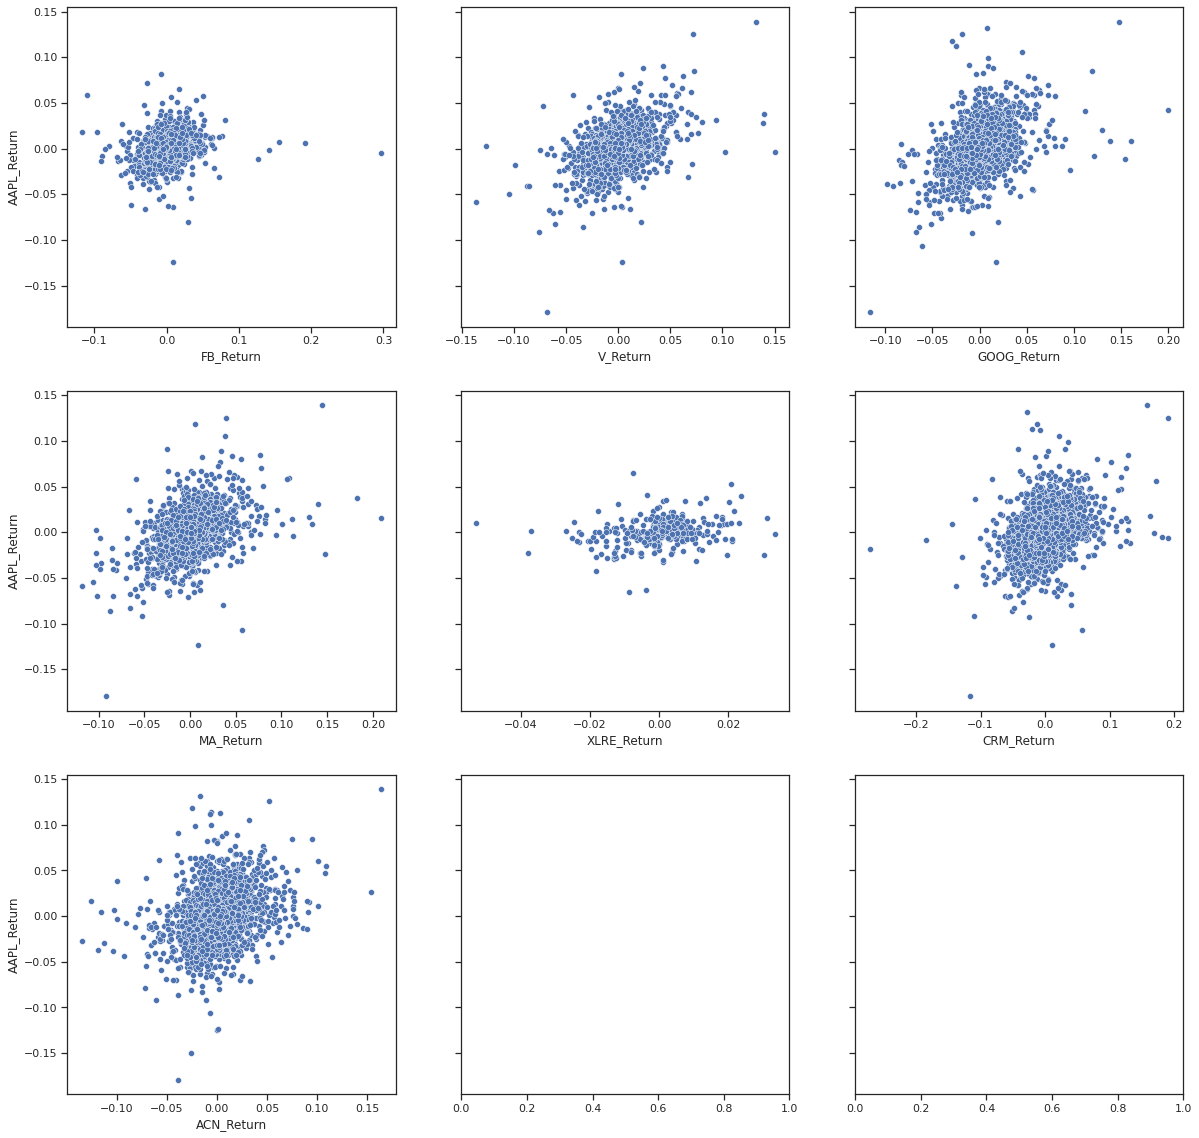

In [ ]:
#drop_columns = ["FB_Return","V_Return","GOOG_Return","MA_Return","XLRE_Return","CRM_Return","ACN_Return"]
fig, axes = plt.subplots(3,3,figsize=(20,20),sharey=True)

sns.scatterplot(ax = axes[0,0],y=data_master.loc["2012-05-21":,:]["AAPL_Return"],x=data_master["FB_Return"])
sns.scatterplot(ax = axes[0,1],y=data_master["AAPL_Return"],x=data_master["V_Return"])
sns.scatterplot(ax = axes[0,2],y=data_master["AAPL_Return"],x=data_master["GOOG_Return"])
sns.scatterplot(ax = axes[1,0],y=data_master["AAPL_Return"],x=data_master["MA_Return"])
sns.scatterplot(ax = axes[1,1],y=data_master["AAPL_Return"],x=data_master["XLRE_Return"])
sns.scatterplot(ax = axes[1,2],y=data_master["AAPL_Return"],x=data_master["CRM_Return"])
sns.scatterplot(ax = axes[2,0],y=data_master["AAPL_Return"],x=data_master["ACN_Return"])


- We can see the AAPL returns have a linear relationship with returns of XLRE and GOOG
- Relationship with ACN_Returns seem random

## Checking correlations
- Pearson correlation is a way to measure the linear dependence between variables
- Here we construct a correlation heat map to understand the relationship between returns

<Figure size 1440x1440 with 0 Axes>

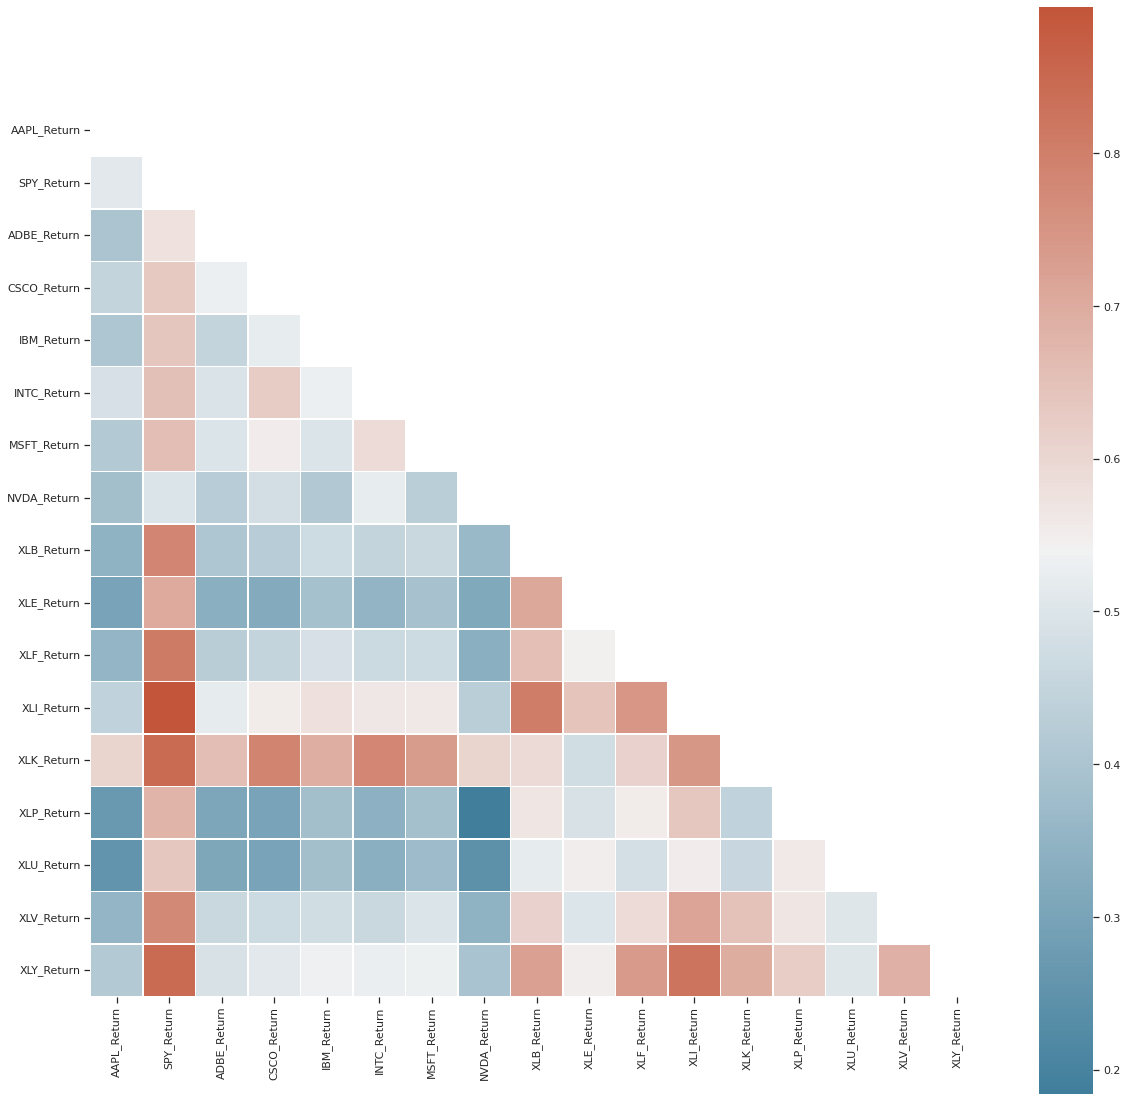

In [ ]:
plt.figure(figsize=(20,20))
#finding correlations
data_pairplot_corr = data_pairplot.corr()

#mask for the plot
mask = np.triu(np.ones_like(data_pairplot_corr, dtype=bool))

#color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#heatmap
sns.heatmap(data_pairplot_corr, mask=mask, cmap =cmap, square=True, linewidths=.5)

- From this we can see that AAPL returns are highly correlated with SPY_Returns, INTC_Returns and XLK_Returns
- They have very little correlation with returns of XLP and XLU




----

- Now let's look at the correlations with the features that have missing values
- We first find the date range of the avaialable data; correlation metrics are caluculated for this range


In [ ]:
#finding date range for the below columns
drop_columns = ["FB_Return","V_Return","GOOG_Return","MA_Return","XLRE_Return","CRM_Return","ACN_Return"]

dict_corr_na = {}

for i in drop_columns:
    df_corr_na = data_master.loc[:,i]
    df_corr_na = df_corr_na[df_corr_na.notnull()]

    #storing date range as tuple
    dict_corr_na.update({i:(min(df_corr_na.index),max(df_corr_na.index))})

#printing date ranges
print(dict_corr_na)

{'FB_Return': ('2012-05-21', '2016-12-30'), 'V_Return': ('2008-03-20', '2016-12-30'), 'GOOG_Return': ('2004-08-20', '2016-12-30'), 'MA_Return': ('2006-05-26', '2016-12-30'), 'XLRE_Return': ('2015-10-09', '2016-12-30'), 'CRM_Return': ('2004-06-24', '2016-12-30'), 'ACN_Return': ('2001-07-20', '2016-12-30')}


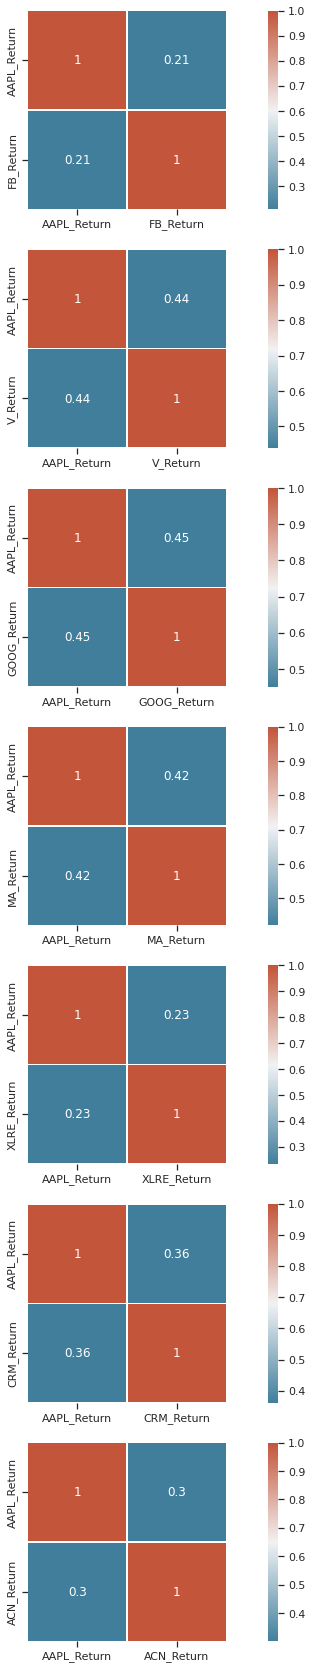

In [ ]:
fig, axes = plt.subplots(7,figsize=(15,30))

k=0; #plot iterator

for i in dict_corr_na.keys():
  a = dict_corr_na[i][0] #starting point
  b = dict_corr_na[i][1] #ending point
  data_corr_na = data_master[["AAPL_Return",i]]
  data_corr_na = data_corr_na[a:b]
  _ = sns.heatmap(ax = axes[k],data = data_corr_na.corr(),cmap =cmap, square=True, linewidths=.5,cbar=True, annot = True);
  k +=1


- From the above we can see that AAPL returns have relatively high correlation with returns of GOOG, MA, V
- The correlation is low with returns of FB and XLRE
- Considering all of these features are missing data, we can adjust our date range to match the ones with high correlations and drop the ones with low correlation from our features list

## **Visualizing Data for Apple stock**
- Before we move onto training our model, let's visualize AAPL return time series

**Plotting Apple stock Returns Vs. Time**

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Apple returns')

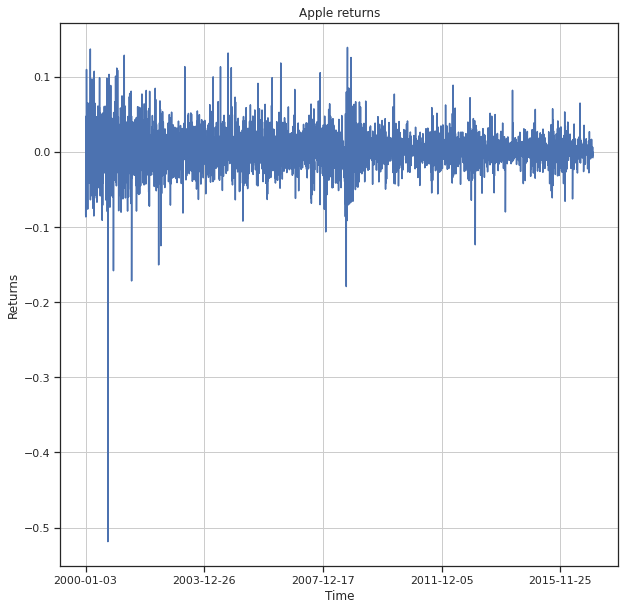

In [ ]:
#Plotting apple returns Vs. Time
plt.figure(figsize=(10,10))
data_master["AAPL_Return"].plot()
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Apple returns")
plt.grid()

- From the above graph we can conclude that the returns of Apple stock are generally centered around 0 with few jumps
- The extreme drop of ~50% in the stock price is valid. A link to the Sep 29, 2000 CNN article.
https://money.cnn.com/2000/09/29/markets/techwrap/

- Considering stock returns are often correlated with revenue which can exhibit seasonality, let's look at the returns in a single year to investigate
- We look at the return data from 2015 to 2016

### Checking for seasonality

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Apple returns')

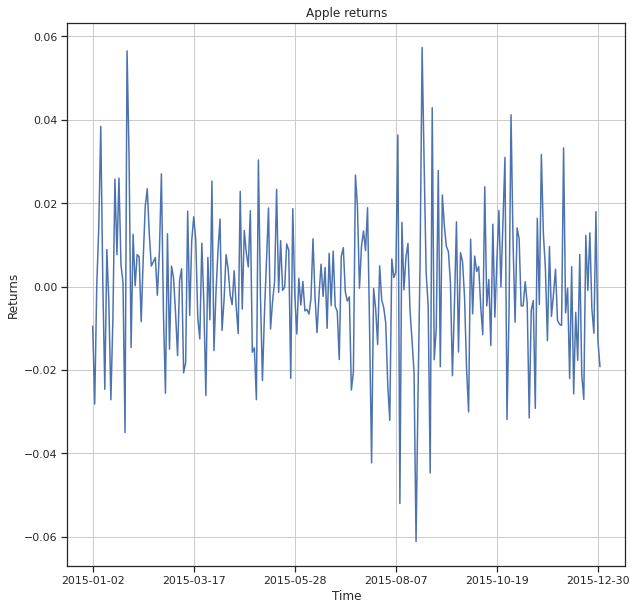

In [ ]:
plt.figure(figsize=(10,10))
data_master["2015-01-01":"2016-01-01"]["AAPL_Return"].plot()
plt.xlabel("Time")
plt.ylabel("Returns")
plt.title("Apple returns")
plt.grid()

- By looking at the above graph, we cannot really conclude the existence of seasonality
- To investigate this further lets compute the means of returns grouping by month

Text(0.5, 0, 'Month')

Text(0, 0.5, 'Mean returns')

Text(0.5, 1.0, 'Apple returns per month')

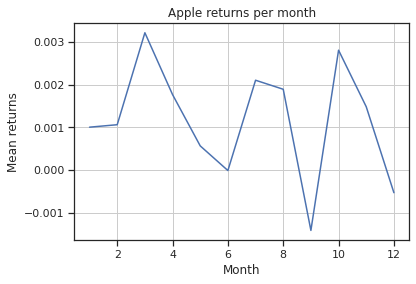

In [ ]:
data_AAPL = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
idx = pd.to_datetime(data_AAPL.index)
data_AAPL = data_AAPL.set_index(idx)
data_AAPL = data_AAPL.groupby(by=data_AAPL.index.month).mean()

#plotting mean returns
data_AAPL["AAPL_Return"].plot()
plt.xlabel("Month")
plt.ylabel("Mean returns")
plt.title("Apple returns per month")
plt.grid()

- Looks like the returns are generally higher in the months of March and October. This might be due to new product launches in the previous months
- September returns seem to be generally low; the sales might decrease due to anticipated new product availability in October
- The above graph suggest seasonality in Apple returns. We can include the seasonality factor through OHE in models
- But we need to note that these are mean returns for a month, but as observed before they is a lot of variation in returns in any given month. So even though we confirm sesonality, it might not be all useful when are implementing some recurrent neural networks which look into the past

### Checking correlations with historical price data
- Let's check the correlation of Apple returns with pricing information like High, Low, Open , Close, Volume and Div

<Figure size 720x720 with 0 Axes>

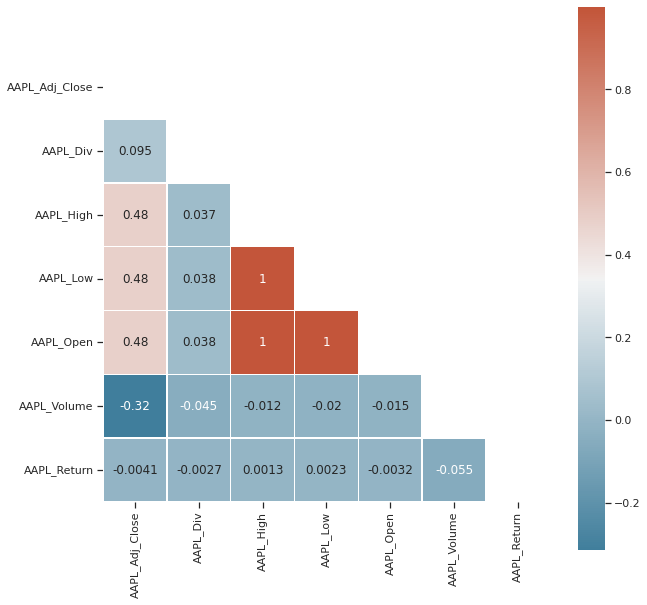

In [ ]:
plt.figure(figsize=(10,10))

#finding correlation
data_AAPL_corr = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"].corr()

#mask for the plot
mask = np.triu(np.ones_like(data_AAPL_corr, dtype=bool))

#color palette
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#heatmap
sns.heatmap(data_AAPL_corr, mask=mask, cmap =cmap, square=True, linewidths=.5,annot = True)


- The pearson correlations of Apple Returns with other Apple features are neglible. This might be due to non-linear nature of the relationship between the target and features

#Baseline model

- Now let's build a baseline Sequential model only with the data columns from Apple
- We will standardized our data before passing it to the Neural Network


In [ ]:
#getting data
data_AAPL = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
data_AAPL = data_AAPL.iloc[1:,:]

#printing shape of the input
print("Dimensions of raw input data", data_AAPL.shape)

Dimensions of raw input data (4276, 7)


In [ ]:
#Splitting the target and features
y_base = data_AAPL["AAPL_Return"]
X_base = data_AAPL.loc[:,"AAPL_Adj_Close":"AAPL_Volume"]

#printing dimensions of the target and features before splitting
print("Dimensions of target before splitting", y_base.shape)
print("Dimensions of features before splitting", X_base.shape)

Dimensions of target before splitting (4276,)
Dimensions of features before splitting (4276, 6)


- Considering our data is a time series, we will perform the test train split using dates
- We will use 2016 data as our testing data set. The remaining would be our training data set

In [ ]:
#training data sets
X_train_base = X_base.loc[:"2015-12-31",:]
y_train_base = y_base.loc[:"2015-12-31"]

#testing data sets
X_test_base = X_base.loc["2016-01-01":,:]
y_test_base = y_base.loc["2016-01-01":]

#printing Dimensions
print("Dimensions of training features", X_train_base.shape)
print("Dimensions of training target", y_train_base.shape)
print("Dimensions of testing features", X_test_base.shape)
print("Dimensions of testing target", y_test_base.shape)

Dimensions of training features (4024, 6)
Dimensions of training target (4024,)
Dimensions of testing features (252, 6)
Dimensions of testing target (252,)


- Now, let's normalize our data. This is an essential pre-processing steps for applying neural networks
- Even though the stock returns are known to be normally distributed, the real world data maynot be exactly normal
- Hence we use MinMaxScaler from Sklearn library for our scaling instead of StandardScaler which assumes a Gaussian distribution

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #creating a scalar object
X_train_base = scaler.fit_transform(X_train_base) #fitting and transforming the training data

X_test_base = scaler.transform(X_test_base) #transforming the test data set using the same scaler

- Now, let's build a sequential model to predict the stock returns

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
    
#shape of input of a single example
input_shape = X_train_base[0].shape

#base model
model_base = tf.keras.Sequential()

#first layer dense
layer_1 = Dense(16, name = "dense_head", activation="relu",input_shape=input_shape) 
model_base.add(layer_1)

#second layer dense
layer_2 = Dense(32, name = "dense_1", activation="relu") 
model_base.add(layer_2)

#third layer dense
layer_3 = Dense(64, name = "dense_2", activation="relu") 
model_base.add(layer_3)

#the output layer
layer_output = Dense(1,activation="linear")
model_base.add(layer_output)

#compiling
model_base.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_head (Dense)           (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,833
Trainable params: 2,833
Non-trainable params: 0
_________________________________________________________________


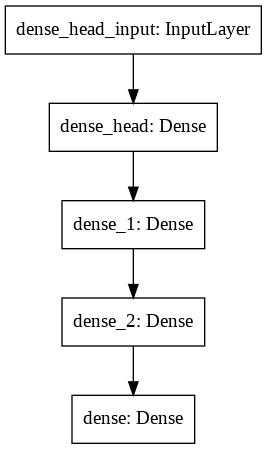

In [ ]:
plot_model(model_base)

In [ ]:
#fitting
history_base = model_base.fit(X_train_base,y_train_base,epochs=15)

Epoch 1/15
126/126 [==============================] - 1s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0204
Epoch 2/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0190 - mean_absolute_error: 0.0190
Epoch 3/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188
Epoch 4/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188
Epoch 5/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0189
Epoch 6/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0189
Epoch 7/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188
Epoch 8/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.0189
Epoch 9/15
126/126 [==============================] - 0s 2ms/step - loss: 0.0188 - mean_absolute_error: 0.0188
E

8/8 [==============================] - 0s 2ms/step - loss: 0.0112 - mean_absolute_error: 0.0112
Sequential_base: Test loss: 0.01 


<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


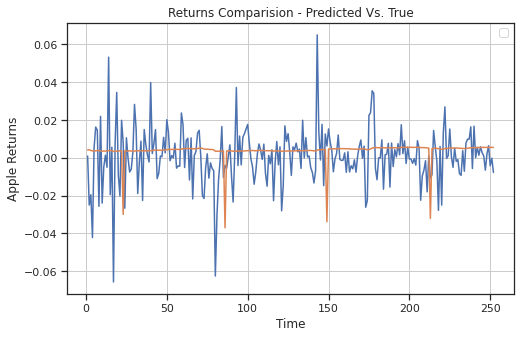

In [ ]:
#predicting results
y_test_pred_base = model_base.predict(X_test_base)

#model name
model_name = "Sequential_base"

#evaluating the test data
score_base = model_base.evaluate(x=X_test_base,y=y_test_base)

print("{n:s}: Test loss: {l:3.2f} ".format(n=model_name, l=score_base[0]))

#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test_base)+1),y_test_base)
plt.plot(range(1,len(y_test_pred_base)+1),y_test_pred_base)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

- As we can see that our base model is not able to predict much variation in the returns.
- Possible reason for this is that we are not taking the previous values into consideration here
- This model can be probably improved by using Auto regressive features or an RNN/LSTM based model which can predict the returns by considering the past values
- We will explore these models in future sections

#Feature Engineering
- In this section we will try to create some additional features for solving our problem

##Technical Indicators
- Many traders and retail investors depend on technical analysis for identifying the signal in stock moments
- Maybe some of the widely used indicators like Moving Average (MA), Exponential moving average (EMA), MACD etc., might be helpful in our case
- **We create a new column called AAPL_Return_yesterday and use it to create these technical indicators. This ensures that we aren't looking into the future(time t) while predicting the returns**


In [ ]:
#Function Definition - Creating Technical indicators on a dataset
def populate_tech_ind(df):

  #previous returns
  df["AAPL_Return_yesterday"] = df["AAPL_Return"].shift(1)

  #creating moving averages
  df["MA7"] = df["AAPL_Return_yesterday"].rolling(window=7).mean()
  df["MA21"] = df["AAPL_Return_yesterday"].rolling(window=21).mean()

  #creating MACD
  df['26EMA'] = df['AAPL_Return_yesterday'].ewm(span=20).mean() #defining span for the decay
  df['12EMA'] = df['AAPL_Return_yesterday'].ewm(span=12).mean() 
  df['MACD'] = (df['12EMA']-df['26EMA'])

  # creating Bollinger Bands
  
  df["20_std"] = df["AAPL_Return_yesterday"].rolling(20).mean() #using 20 day standard deviation
  df['Upper_band'] = df['MA21'] + (df['20_std']*1) #bands with 1 standard deviation
  df['Lower_band'] = df['MA21'] - (df['20_std']*1) #bands with 1 standard deviation

  # creating Exponential moving average
  df['EMA'] = df['AAPL_Return_yesterday'].ewm(com=0.5).mean() #simple moving average
  
  return df

- We now create three new indicators based on suggestions from NYU's course
  - Rate of Change Oscillator 
    - M = (V-V10_)*100
  - Relative Strength Index(RSI)
  - Stochastic Oscillator

- We also give the populate_ind_2 a parameter for window

  

In [ ]:
def populate_ind_2(df,window_):

  df["RCO"] = df["AAPL_Return_yesterday"].diff(periods=10) # Rate of Change Oscillator

  #----------price metrics--------------------------------------#
  #previous price
  df["AAPL_Adj_Close_yesterday"] = df["AAPL_Adj_Close"].shift(1)

  #up down calculation
  df["Price_Up/down"] = df["AAPL_Adj_Close_yesterday"].diff() > 0
  df["Price_Up/down"] = df["Price_Up/down"].astype(int)
  df["RS"] = df["Price_Up/down"].rolling(window=window_).sum()/(window_-df["Price_Up/down"].rolling(window=window_).sum()) #using 14 day window
  df["RSI"] = 100 - (100/(1+df["RS"])) #RSI

  #Window high and low
  df["Historical High"] = df["AAPL_Adj_Close_yesterday"].rolling(window=window_).max()
  df["Historical Low"] = df["AAPL_Adj_Close_yesterday"].rolling(window=window_).min()

  #stochastic oscillator
  df["SO %K"] = 100*(df["AAPL_Adj_Close_yesterday"]-df["Historical Low"])/(df["Historical High"]-df["Historical Low"])
  df["SO %D"] = df["SO %K"].rolling(3).mean()

  return df



## Feature importances
- In this section we employ XGBoost algorithm to find out feature importances
- We will use the features which do not have missing values. We acheive this by dropping columns with missing price data (drop_columns)

In [ ]:
#function to drop columns containing names
def drop_names(df,drop_list):
  for i in range(len(drop_list)):
    filter = df.columns.str.startswith(drop_list[i]) #check for columns starting with
    df = df.loc[:,list(~filter)] #dropping the columns
  return df

In [ ]:
#getting data
drop_columns = ["FB","V","GOOG","MA","XLRE","CRM","ACN"] #list containing stock names for us to drop
data_XGboost = drop_names(data_master,drop_columns)

#printing dimensions
print("Dimensions of the data before dropping columns : ",data_master.shape)
print("Dimensions of the data after dropping columns : ",data_XGboost.shape)

Dimensions of the data before dropping columns :  (4277, 168)
Dimensions of the data after dropping columns :  (4277, 119)


In [ ]:
#populating technical indiators
data_XGboost = populate_tech_ind(data_XGboost) 
data_XGboost = populate_ind_2(data_XGboost,14) #choosing the window size as 14 days

#dropping NaN columns - drop the first 21 rows as they do not have MA21 and other features available
data_XGboost = data_XGboost.iloc[22:,:]
print("Dimensions of the data after adding technical indicators : ",data_XGboost.shape)
print("Number of NaN values : ", data_XGboost.isna().sum().sum())

Dimensions of the data after adding technical indicators :  (4255, 138)
Number of NaN values :  0


In [ ]:
#Splitting the target and features
y_XGboost = data_XGboost["AAPL_Return"]
X_XGboost = data_XGboost.drop(columns=["AAPL_Return"])

#printing dimensions of the target and features before splitting
print("Dimensions of target before splitting", y_XGboost.shape)
print("Dimensions of features before splitting", X_XGboost.shape)
print("-"*40)

#training data sets
X_train_XGboost = X_XGboost.loc[:"2015-12-31",:]
y_train_XGboost = y_XGboost[:"2015-12-31"]

#testing data sets
X_test_XGboost = X_XGboost.loc["2016-01-01":,:]
y_test_XGboost = y_XGboost.loc["2016-01-01":]

#printing Dimensions
print("Dimensions of training features", X_train_XGboost.shape)
print("Dimensions of training target", y_train_XGboost.shape)
print("Dimensions of testing features", X_test_XGboost.shape)
print("Dimensions of testing target", y_test_XGboost.shape)

Dimensions of target before splitting (4255,)
Dimensions of features before splitting (4255, 137)
----------------------------------------
Dimensions of training features (4003, 137)
Dimensions of training target (4003,)
Dimensions of testing features (252, 137)
Dimensions of testing target (252,)


In [ ]:
#scaling the data set
scaler_XGBoost = MinMaxScaler() #creating a scalar object
X_train_XGboost = scaler_XGBoost.fit_transform(X_train_XGboost) #fitting and transforming the training data

from xgboost import XGBRegressor,cv
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model_XGBoost = XGBRegressor(random_state = 42,use_label_encoder=False)

#fiiting
model_XGBoost.fit(X_train_XGboost,y_train_XGboost)

#Cross Validation
cross_val_score_XGBoost = cross_val_score(model_XGBoost,X_train_XGboost,y_train_XGboost)
print("Average Cross Val Score : ", cross_val_score_XGBoost.mean())

#predicting
y_train_XGboost_pred = model_XGBoost.predict(X_train_XGboost)
print("In sample MAE :", mean_squared_error(y_train_XGboost,y_train_XGboost_pred))

X_test_XGboost = scaler_XGBoost.transform(X_test_XGboost) #scaling
y_test_XGboost_pred = model_XGBoost.predict(X_test_XGboost)
print("Out of sample MAE :", mean_squared_error(y_test_XGboost,y_test_XGboost_pred))


[16:04:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, use_label_encoder=False, verbosity=1)

[16:05:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:05:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:05:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Cross Val Score :  0.28276367564089855
In sample MAE : 0.0002952055641877233
Out of sample MAE : 0.00013552419795478693


- The in sample and out of sample MAE from XGBoost are very satisfactory. This suggests that our newly created features are working well
- But the main goal of this section is to identify feature importances, which we will do now

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Feature Importance Value')

Text(0.5, 1.0, 'Feature Importances from XGBoost')

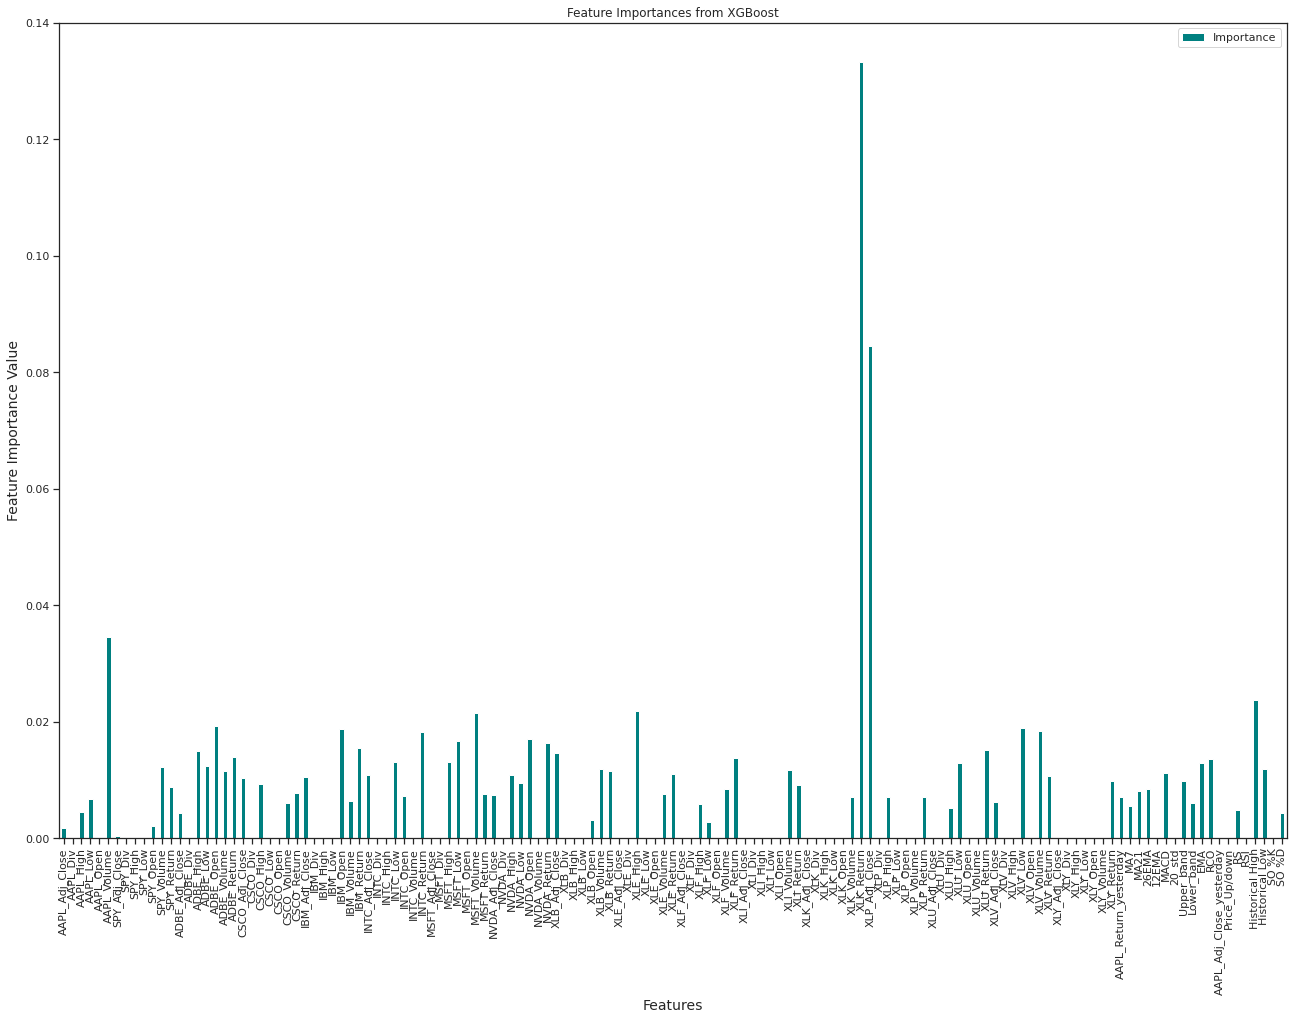

In [ ]:
#getting the importance
importance_rf_XGboost = model_XGBoost.feature_importances_

#creating data frame for visualization
index = pd.DataFrame(X_XGboost).columns
importance_rf_XGboost_df = pd.DataFrame({"Importance":importance_rf_XGboost}, index=index)

plt.rcParams['figure.figsize'] = [22, 15]
importance_rf_XGboost_df.plot.bar(color="teal")
plt.xlabel("Features",fontsize=14)
plt.ylabel("Feature Importance Value",fontsize=14)
plt.title("Feature Importances from XGBoost")
plt.show()


In [ ]:
print("Top 50 features based on XGBoost Feature importances")
print("*"*50)

importance_rf_XGboost_df.sort_values("Importance",ascending = False).head(50)

Top 50 features based on XGBoost Feature importances
**************************************************


,Importance
XLK_Return,0.133341
XLP_Adj_Close,0.084471
AAPL_Volume,0.034544
Historical High,0.023771
XLE_High,0.021781
MSFT_Volume,0.021564
ADBE_Open,0.019217
XLV_Low,0.018976
IBM_Open,0.018783
XLV_Volume,0.018347


- As identified in the EDA, XLK_Return seem to be the most important feature
- newly added technical indicators are also in the top 50 features
- Some of the new features like RSI do not have much significance. But they are captured in calculating other technical features which have high significance

#LSTM


## Data Preprocessing | creating features | splitting data into train and test datasets

In [ ]:
#getting data
drop_columns = ["FB","V","GOOG","MA","XLRE","CRM","ACN"] #list containing stock names for us to drop
data_LSTM = drop_names(data_master,drop_columns)

#populating technical indiators
data_LSTM = populate_tech_ind(data_LSTM) 
data_LSTM = populate_ind_2(data_LSTM,14) #choosing the window size as 14 days

#dropping NaN columns - drop the first 21 rows as they do not have MA21 and other features available
data_LSTM = data_LSTM.iloc[22:,:]
print("Dimensions of the data after adding technical indicators : ",data_LSTM.shape)
print("Number of NaN values : ", data_LSTM.isna().sum().sum())

#Splitting the target and features
y_LSTM = data_LSTM["AAPL_Return"]
X_LSTM = data_LSTM.drop(columns=["AAPL_Return"])

#training data sets
X_train_LSTM = X_LSTM.loc[:"2015-12-31",:]
y_train_LSTM = y_LSTM.loc[:"2015-12-31"]

#testing data sets
X_test_LSTM = X_LSTM.loc["2016-01-01":,:]
y_test_LSTM = y_LSTM.loc["2016-01-01":]

#printing Dimensions
print("Dimensions of training features", X_train_LSTM.shape)
print("Dimensions of training target", y_train_LSTM.shape)
print("Dimensions of testing features", X_test_LSTM.shape)
print("Dimensions of testing target", y_test_LSTM.shape)

Dimensions of the data after adding technical indicators :  (4255, 138)
Number of NaN values :  0
Dimensions of training features (4003, 137)
Dimensions of training target (4003,)
Dimensions of testing features (252, 137)
Dimensions of testing target (252,)


- Let's scale our data.
- Here, we use MinMax Scaler from scikit learn

In [ ]:
scaler_LSTM = MinMaxScaler() #creating a scalar object
X_train_LSTM = scaler_LSTM.fit_transform(X_train_LSTM) #fitting and transforming the training data

#transforming test data for convinience
X_test_LSTM = scaler.fit_transform(X_test_LSTM) #fitting and transforming the training data

- Now lets transform our train and test data for feeding into the LSTM model

## Creating the data structure required for LSTM
- Here we try to feed the model past data for n_steps. Hence our input will actually be in 3d
- The below code tries to reshape the data sets for training and testing

In [ ]:
n_steps = 60
X_train = []
y_train = []
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_train_LSTM)):
    X_train.append(X_train_LSTM[i-n_steps:i,:])
    y_train.append(y_train_LSTM[i])

#for testing data set
for i in range(n_steps,len(X_test_LSTM)):
    X_test.append(X_test_LSTM[i-n_steps:i,:])
    y_test.append(y_test_LSTM[i])

In [ ]:
#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#reshaping the test data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)
print("Dimensions of testing features", X_test.shape)
print("Dimensions of testing target", y_test.shape)

Dimensions of training features (3943, 60, 137)
Dimensions of training target (3943,)
Dimensions of testing features (192, 60, 137)
Dimensions of testing target (192,)


##Creating the model

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential

- Ideally, the longer you train the better the model should get. But this always doesn't happen and your loss can increase after certain number of epochs
- We use early stopping time to counter this. We use a patience of 10, meaning the call back will observe 10 consective epochs and stop training if our metric(val_loss) here worsens
- We also use the test data set created before as our validation data set for convinience

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00005, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

#callbacks = [ es_callback,ModelCheckpoint(filepath= "best_model.ckpt", monitor='mean_absolute_error', save_best_only=True)]


In [ ]:
max_epochs = 100

model_LSTM = Sequential()

#adding LSTm layer
layer_LSTM = LSTM(60,input_shape=(X_train.shape[1],X_train.shape[2]))
model_LSTM.add(layer_LSTM)

#adding Dense
model_LSTM.add(Dense(1))

#compiling
model_LSTM.compile(loss='mean_absolute_error', optimizer='adam')
model_LSTM.summary()

#fitting
history_LSTM = model_LSTM.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                47520     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 47,581
Trainable params: 47,581
Non-trainable params: 0
_________________________________________________________________


## Results

6/6 [==============================] - 0s 3ms/step - loss: 0.0125
--------------------------------------------------
LSTM_V1: Test loss: 0.01253 
--------------------------------------------------


<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


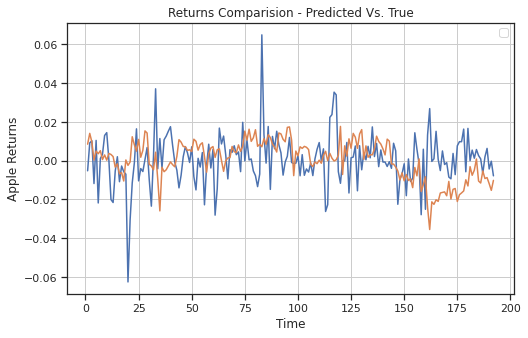

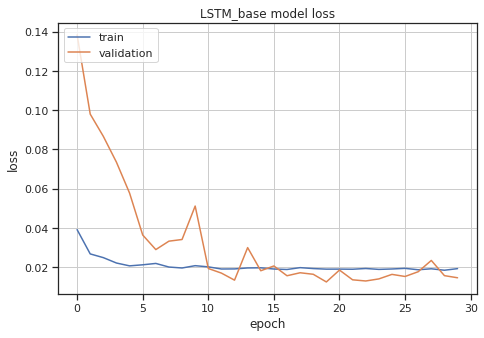

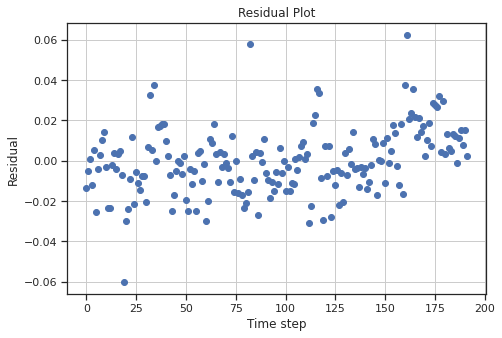

In [ ]:
#predictions
y_test_pred = model_LSTM.predict(X_test)

#evaluating the test data
score = model_LSTM.evaluate(x=X_test,y=y_test)

print("-"*50)
print("{n:s}: Test loss: {l:5.5f} ".format(n="LSTM_V1", l=score))
print("-"*50)

#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM,"LSTM_base")
plot_residual(y_test,y_test_pred)

- Our LSTM model with one layer is able to track the general movement of the returns, but it struggles in capturing the big jumps

- The residuals from our model, do not have a noticeable pattern. But we can see that they under predict the returns in the later part.

- The validation loss is a little unstable suggesting some problems in convergence. But the low/comparable loss values for our test and train data set suggest **no serious over fitting** 

- We can probably address some these problems probably by adding a drop out layer

# Stacked LSTM with only Data from Apple and drop outs
- In this section we explore stacking multiple LSTM layers to check whether we can improve our predictions

- This model, we will use only Apple stock data and create technical indicators on them 

- We will also introduce dropout layers between different LSTM layers


In [ ]:
#setting this to avoid cluttering te output with chained assignment warnings. I have considered these warning while coding the below cell
pd.set_option('mode.chained_assignment', None)

## Train set preperation

In [ ]:
#getting data
data_LSTM = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]

#splitting into test and train
data_LSTM_train = data_LSTM.loc[:"2015-12-31",:]
data_LSTM_test = data_LSTM.loc["2016-01-01":,:]

#populating technical indiators
data_LSTM_train = populate_tech_ind(data_LSTM_train) 
data_LSTM_train = populate_ind_2(data_LSTM_train,14)
data_LSTM_train = data_LSTM_train.iloc[22:,:]

#storing index and columns
index = data_LSTM_train.index
columns = data_LSTM_train.columns

#scaling test and train data seperately
scaler_LSTM = MinMaxScaler() #creating a scalar object
data_LSTM_train = scaler_LSTM.fit_transform(data_LSTM_train) #fitting and transforming the training data

#converting the scaled data 
data_LSTM_train = pd.DataFrame(data_LSTM_train,index=index,columns=columns)

data_LSTM_train.head()

#Splitting the target and features
y_train_LSTM = data_LSTM_train["AAPL_Return"]
X_train_LSTM = data_LSTM_train.drop(columns=["AAPL_Return"])

n_steps = 30
X_train = []
y_train = []

#for training data set
for i in range(n_steps,len(X_train_LSTM)):
    X_train.append(X_train_LSTM.iloc[i-n_steps:i,:])
    y_train.append(y_train_LSTM[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)

,AAPL_Adj_Close,AAPL_Div,AAPL_High,AAPL_Low,AAPL_Open,AAPL_Volume,AAPL_Return,AAPL_Return_yesterday,MA7,MA21,26EMA,12EMA,MACD,20_std,Upper_band,Lower_band,EMA,RCO,AAPL_Adj_Close_yesterday,Price_Up/down,RS,RSI,Historical High,Historical Low,SO %K,SO %D
Dt,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-02-03,0.019638,0.0,0.131612,0.127437,0.126662,0.059040,0.857821,0.766783,0.637148,0.619740,0.643324,0.636890,0.627507,0.669723,0.643347,0.647438,0.707946,0.405171,0.018492,0.0,0.064935,0.454545,0.021616,0.018496,0.123151,0.416336
2000-02-04,0.020833,0.0,0.139923,0.132351,0.131920,0.052285,0.857601,0.857821,0.625727,0.716943,0.715552,0.711412,0.697293,0.693977,0.704381,0.797628,0.803079,0.423160,0.019638,1.0,0.064935,0.454545,0.021616,0.019037,0.306310,0.308638
2000-02-07,0.022378,0.0,0.146066,0.135718,0.137817,0.054418,0.873949,0.857601,0.692184,0.739965,0.779090,0.773722,0.750181,0.797538,0.768044,0.631449,0.834571,0.498925,0.020833,1.0,0.064935,0.454545,0.021616,0.019037,0.625548,0.351670
2000-02-08,0.022584,0.0,0.148776,0.143452,0.146514,0.050025,0.799409,0.873949,0.752461,0.846776,0.850132,0.840766,0.802432,0.804403,0.825157,0.837296,0.861320,0.532154,0.022378,1.0,0.064935,0.454545,0.021759,0.019037,1.000000,0.643953
2000-02-09,0.022011,0.0,0.150221,0.145182,0.146696,0.035223,0.758827,0.799409,0.839242,0.816622,0.846180,0.830284,0.781836,0.823795,0.819764,0.735191,0.796138,0.396362,0.022584,1.0,0.064935,0.454545,0.021966,0.019037,1.000000,0.875183


Dimensions of training features (3973, 30, 25)
Dimensions of training target (3973,)


## Test Set preperation


In [ ]:
#populating technical indiators
data_LSTM_test = populate_tech_ind(data_LSTM_test) 
data_LSTM_test = populate_ind_2(data_LSTM_test,14)
data_LSTM_test = data_LSTM_test.iloc[22:,:]

#storing index and columns
index = data_LSTM_test.index
columns = data_LSTM_test.columns

#scaling test and train data seperately
data_LSTM_test = scaler_LSTM.transform(data_LSTM_test) #transforming the test data

#converting the scaled data 
data_LSTM_test = pd.DataFrame(data_LSTM_test,index=index,columns=columns)

#Splitting the target and features
y_test_LSTM = data_LSTM_test["AAPL_Return"]
X_test_LSTM = data_LSTM_test.drop(columns=["AAPL_Return"])

n_steps = 30
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_test_LSTM)):
    X_test.append(X_test_LSTM.iloc[i-n_steps:i,:])
    y_test.append(y_test_LSTM[i])

#reshaping the train data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_test.shape)
print("Dimensions of training target", y_test.shape)

Dimensions of training features (200, 30, 25)
Dimensions of training target (200,)


## Call backs

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.00005, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [ ]:
#parameters
max_epochs = 100

model_LSTM_v2 = Sequential()

#adding LSTm layer
model_LSTM_v2.add(LSTM(60,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model_LSTM.add(Dropout(0.2))
model_LSTM_v2.add(LSTM(60, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM_v2.add(LSTM(60, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM_v2.add(LSTM(60))
#adding Dense
model_LSTM_v2.add(Dense(1))

#compiling
model_LSTM_v2.compile(loss='mean_absolute_error', optimizer='adam')
model_LSTM_v2.summary()

#fitting
history_LSTM_v2 = model_LSTM_v2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,callbacks=es_callback)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 60)            20640     
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
lstm_9 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 107,821
Trainable params: 107,821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 9s 23ms/step - loss: 0.1264 - val_loss: 0.0159
Epoch 2/100


7/7 [==============================] - 0s 6ms/step - loss: 0.0137
--------------------------------------------------
LSTM_V1: Test loss: 0.01368 
--------------------------------------------------


<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


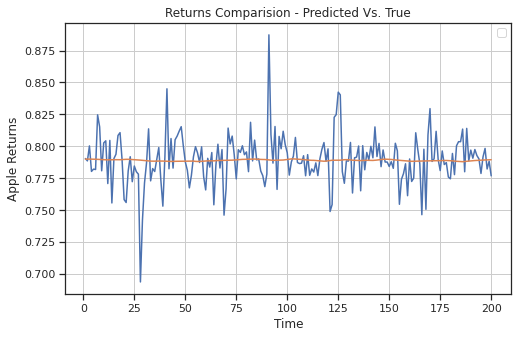

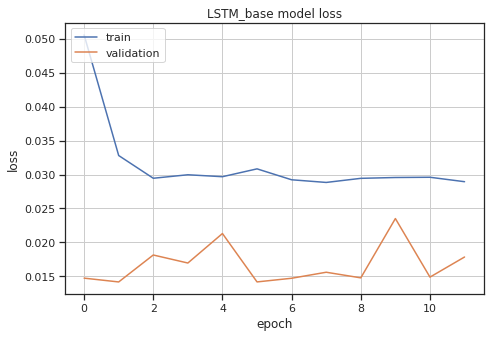

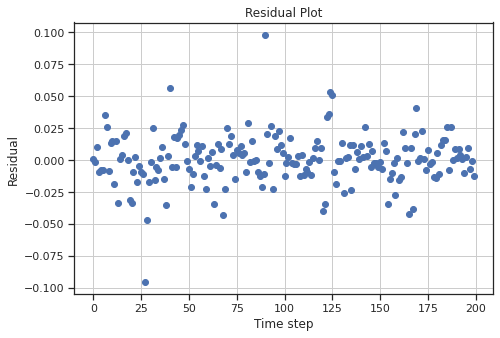

In [ ]:
#predictions
y_test_pred = model_LSTM_v2.predict(X_test)

#evaluating the test data
score = model_LSTM_v2.evaluate(x=X_test,y=y_test)

print("-"*50)
print("{n:s}: Test loss: {l:5.5f} ".format(n="LSTM_V1", l=score))
print("-"*50)

#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM,"LSTM_base")
plot_residual(y_test,y_test_pred)

- Our loss actually increased from the single LSTM layer model
- We can also see that the model is not able to capture mych variation in the returns time series
- The validation loss plateaus suggesting some that the model is unable to lean more
- Maybe stacked LSTM is not appropriate for our model

#LSTM with higher learning rate and scaled targets
- As mentioned earlier scaling is an important steps in data preprocessing for a neural network. It helps the model learn better and converge faster
- Previously we have not scaled our targets. Considering all of them are small and close to zero, our model might be learning better in teh previous
- Here we scale our targets in the hope of improving the predictions. We also use a different scaler for the target for the convinience of inverse transform later for predictions
- We also increase learning rate to 0.01
- We also remove call_backs to see how our model would perform with 100 epocs without early stopping

In [ ]:
#getting data
data_LSTM = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]

#splitting into test and train
data_LSTM_train = data_LSTM.loc[:"2015-12-31",:]
data_LSTM_test = data_LSTM.loc["2016-01-01":,:]

#populating technical indiators
data_LSTM_train = populate_tech_ind(data_LSTM_train) 
data_LSTM_train = populate_ind_2(data_LSTM_train,14)
data_LSTM_train = data_LSTM_train.iloc[22:,:]

#storing index and columns
index = data_LSTM_train.index
columns = data_LSTM_train.columns

#Splitting the target and features
y_train_LSTM = data_LSTM_train["AAPL_Return"]
X_train_LSTM = data_LSTM_train.drop(columns=["AAPL_Return"])

#scaling test and train data seperately
scaler_LSTM = MinMaxScaler() #creating a scalar object
scaler_LSTM_target = MinMaxScaler()
X_train_LSTM = scaler_LSTM.fit_transform(X_train_LSTM) #fitting and transforming the training data
y_train_LSTM = scaler_LSTM_target.fit_transform(y_train_LSTM.values.reshape(-1,1))

n_steps = 30
X_train = []
y_train = []

#for training data set
for i in range(n_steps,len(X_train_LSTM)):
    X_train.append(X_train_LSTM[i-n_steps:i,:])
    y_train.append(y_train_LSTM[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)

Dimensions of training features (3973, 30, 25)
Dimensions of training target (3973, 1)


In [ ]:
#populating technical indiators
data_LSTM_test = populate_tech_ind(data_LSTM_test) 
data_LSTM_test = populate_ind_2(data_LSTM_test,14)
data_LSTM_test = data_LSTM_test.iloc[22:,:]

#storing index and columns
index = data_LSTM_test.index
columns = data_LSTM_test.columns

#Splitting the target and features
y_test_LSTM = data_LSTM_test["AAPL_Return"]
X_test_LSTM = data_LSTM_test.drop(columns=["AAPL_Return"])

#scaling test and train data seperately
X_test_LSTM = scaler_LSTM.transform(X_test_LSTM) #fitting and transforming the training data
y_test_LSTM = scaler_LSTM_target.transform(y_test_LSTM.values.reshape(-1,1))

n_steps = 30
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_test_LSTM)):
    X_test.append(X_test_LSTM[i-n_steps:i,:])
    y_test.append(y_test_LSTM[i])

#reshaping the train data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_test.shape)
print("Dimensions of training target", y_test.shape)

Dimensions of training features (200, 30, 25)
Dimensions of training target (200, 1)


In [ ]:
#parameters
max_epochs = 100

model_LSTM_v3 = Sequential()

#adding LSTm layer
model_LSTM_v3.add(LSTM(60,return_sequences =False,input_shape=(X_train.shape[1],X_train.shape[2])))
model_LSTM_v3.add(Dropout(0.5))
#adding Dense
model_LSTM_v3.add(Dense(1))

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

#compiling
model_LSTM_v3.compile(loss='mae', optimizer=opt)
model_LSTM_v3.summary()

#fitting
history_LSTM_v3 = model_LSTM_v3.fit(X_train,y_train,batch_size = 10,validation_data=(X_test,y_test),epochs=max_epochs)

#predictions
y_test_pred = model_LSTM_v3.predict(X_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60)                20640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 20,701
Trainable params: 20,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
398/398 [==============================] - 4s 6ms/step - loss: 0.1307 - val_loss: 0.0144
Epoch 2/100
398/398 [==============================] - 2s 5ms/step - loss: 0.0307 - val_loss: 0.0153
Epoch 3/100
398/398 [==============================] - 2s 5ms/step - loss: 0.0284 - val_loss: 0.0160
Epoch 4/100
398/398 [==============================] - 2s 4ms/step - loss: 0.

In [ ]:
#inverse scaling our targets
y_test = scaler_LSTM_target.inverse_transform(y_test)
y_test_pred = scaler_LSTM_target.inverse_transform(y_test_pred)

7/7 [==============================] - 0s 3ms/step - loss: 0.7888
--------------------------------------------------
LSTM_v3: Test loss: 0.78879 
--------------------------------------------------


<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


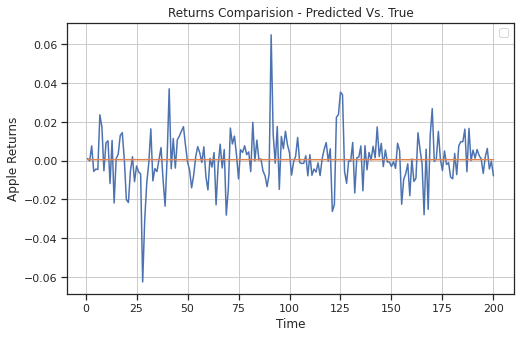

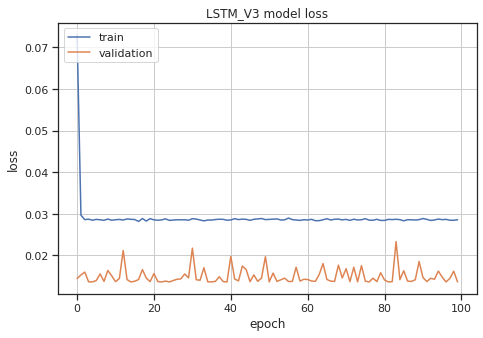

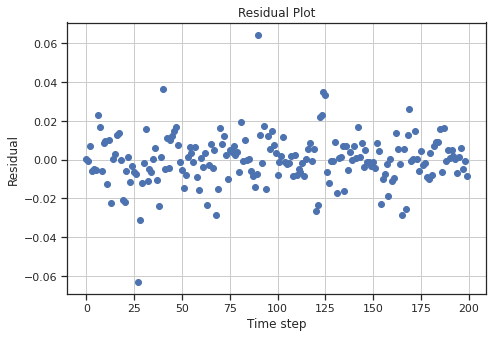

In [ ]:
#evaluating the test data
score = model_LSTM_v3.evaluate(x=X_test,y=y_test)

print("-"*50)
print("{n:s}: Test loss: {l:5.5f} ".format(n="LSTM_v3", l=score))
print("-"*50)

#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM_v3,"LSTM_V3")
plot_residual(y_test,y_test_pred)

- Looks like scaling the targets didnt help much
- Even though we removed early stopping the model did not learn more which is evident from no decrease in the validation loss

#LSTM Model with additional features

- Now, we can try some additional features.
- We will use the stock price data from other timeseries provided in the Data Set
- We refer to the importances from XGBoost Regression to select the best features
- We also decrease the drop out to 0.2 to see if we make the model better

In [ ]:
importance_rf_XGboost_df = importance_rf_XGboost_df.sort_values("Importance",ascending = False)

- Around half of the created features do not have any significance, i.e., their importance is ~0
- Let's remove these features from our data set and run the LSTM model

In [ ]:
features_to_drop = importance_rf_XGboost_df[importance_rf_XGboost_df["Importance"] < 0.000001].index
features_to_drop

Index(['XLI_High', 'XLK_Adj_Close', 'XLE_Adj_Close', 'XLE_Div', 'XLI_Open',
       'XLI_Low', 'XLE_Low', 'XLI_Div', 'XLI_Adj_Close', 'XLK_High',
       'XLE_Open', 'XLF_Open', 'AAPL_Div', 'XLK_Div', 'XLK_Open', 'XLK_Low',
       'XLF_Div', 'XLB_Low', 'XLB_High', 'XLP_Div', 'XLB_Div', 'XLP_Low',
       'XLP_Open', 'XLP_Volume', 'NVDA_Volume', 'XLU_Adj_Close', 'XLU_Div',
       'NVDA_Div', 'MSFT_Open', 'XLU_Open', 'XLU_Volume', 'XLV_Div',
       'XLF_Adj_Close', 'IBM_Div', 'XLY_High', 'IBM_High', 'IBM_Low',
       'XLY_Volume', 'XLY_Open', 'XLY_Low', 'XLY_Adj_Close', 'XLY_Div',
       'INTC_Div', 'INTC_High', 'XLV_Open', 'INTC_Volume', 'XLV_High',
       'CSCO_Low', 'SO %K', 'CSCO_Open', 'MSFT_Adj_Close', '12EMA', 'CSCO_Div',
       '20_std', 'ADBE_Div', 'SPY_Low', 'SPY_High', 'AAPL_Adj_Close_yesterday',
       'Price_Up/down', 'SPY_Div', 'RSI', 'AAPL_Open', 'MSFT_Div'],
      dtype='object')

In [ ]:
#getting data
drop_columns = ["FB","V","GOOG","MA","XLRE","CRM","ACN"] #list containing stock names for us to drop
data_LSTM = drop_names(data_master,drop_columns)

#creating technical indicators
data_LSTM = populate_tech_ind(data_LSTM)
data_LSTM = populate_ind_2(data_LSTM,14)
data_LSTM = data_LSTM.iloc[22:,:]

#splitting into test and train
data_train = data_LSTM.loc[:"2015-12-31",:]
data_test = data_LSTM.loc["2016-01-01":,:]

# #creating technical indicators
# data_train = populate_tech_ind(data_train)
# data_train = populate_ind_2(data_train,14)
# data_train = data_train.iloc[22:,:]

# data_test = populate_tech_ind(data_test)
# data_test = populate_ind_2(data_test,14)
# data_test = data_test.iloc[22:,:]

#dropping redundant features
data_train = data_train.drop(columns=features_to_drop)
data_test = data_test.drop(columns= features_to_drop)

#Splitting the target and features
y_train_LSTM = data_train["AAPL_Return"]
X_train_LSTM = data_train.drop(columns=["AAPL_Return"])

y_test_LSTM = data_test["AAPL_Return"]
X_test_LSTM = data_test.drop(columns=["AAPL_Return"])

#scaling test and train data seperately
scaler_LSTM = MinMaxScaler() #creating a scalar object
X_train_LSTM = scaler_LSTM.fit_transform(X_train_LSTM) #fitting and transforming the training data
X_test_LSTM = scaler_LSTM.transform(X_test_LSTM) #transforming the test data set


n_steps = 5
X_train = []
y_train = []
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_train_LSTM)):
    X_train.append(X_train_LSTM[i-n_steps:i,:])
    y_train.append(y_train_LSTM[i])

for i in range(n_steps,len(X_test_LSTM)):
    X_test.append(X_test_LSTM[i-n_steps:i,:])
    y_test.append(y_test_LSTM[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#reshaping the train data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)
print("Dimensions of testing features", X_test.shape)
print("Dimensions of testing target", y_test.shape)

Dimensions of training features (3998, 5, 74)
Dimensions of training target (3998,)
Dimensions of testing features (247, 5, 74)
Dimensions of testing target (247,)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 74)                44104     
_________________________________________________________________
dropout_8 (Dropout)          (None, 74)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 75        
Total params: 44,179
Trainable params: 44,179
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
125/125 [==============================] - 3s 16ms/step - loss: 0.1004 - val_loss: 0.0126
Epoch 2/100
125/125 [==============================] - 2s 15ms/step - loss: 0.0184 - val_loss: 0.0113
Epoch 3/100
125/125 [==============================] - 2s 14ms/step - loss: 0.0188 - val_loss: 0.0112
Epoch 4/100
125/125 [==============================] - 2s 15ms/step - loss

<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


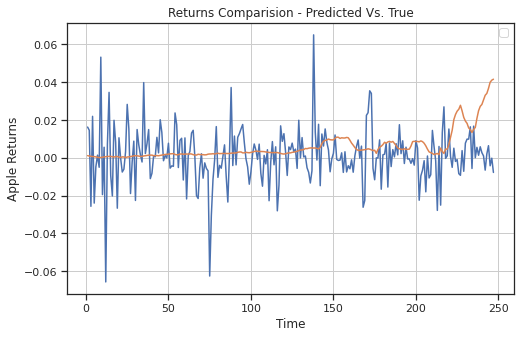

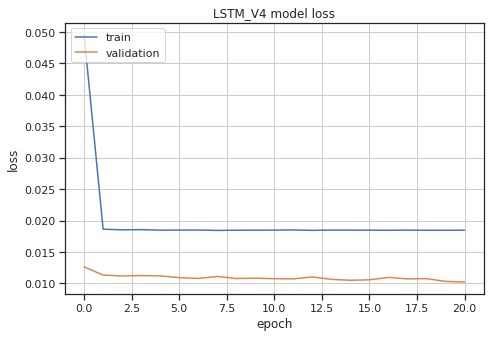

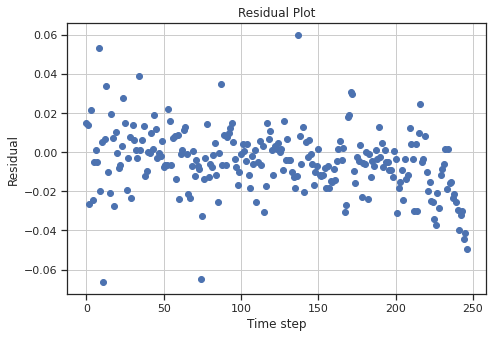

In [ ]:
#callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.005, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

#parameters
max_epochs = 100

model_LSTM_v4 = Sequential()

#adding LSTm layer
model_LSTM_v4.add(LSTM(74,return_sequences =False,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
model_LSTM_v4.add(Dropout(0.5))
#adding Dense
model_LSTM_v4.add(Dense(1,activation="linear"))

#compiling
model_LSTM_v4.compile(loss='mean_absolute_error', optimizer='adam')
model_LSTM_v4.summary()

#fitting
history_LSTM_V4 = model_LSTM_v4.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=max_epochs,callbacks=es_callback)

#predictions
y_test_pred = model_LSTM_v4.predict(X_test)

#evaluating the test data
score = model_LSTM_v4.evaluate(x=X_test,y=y_test)

print("-"*50)
print("{n:s}: Test loss: {l:5.5f} ".format(n="LSTM_V4", l=score))
print("-"*50)

#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM_V4,"LSTM_V4")
plot_residual(y_test,y_test_pred)


- Even though our Loss is small when compared to the previous models, this network is still unable to accurately capture the variations in the return
- Also when we removed early stopping condition and increased the epochs for this same model, we notice that higher epochs help the model to capture some of the variation in returns. But the valication loss increases when we do increase epochs.
- Increasing the learning rate can help the alogorithm to predict the variations, but that creates problems in convergence
- Also adding additional features did not help much in our case

#Variations in LSTM
- So far we used Vanilla LSTM and Stacked LSTM models
- In this section we try some other variations of LSTM like Bidirectional and CNN LSTM
- We will run our model for the following sections with only apple data, as adding additional features is not necessarily improving our predictions


## Bidirectional - LSTM
- In this section we use a Bidirectional LSTM. This model enables the LSTM layer to learn both in the foraward pass and the backward pass, essentially making the model learn model with less number of epochs
- We also increased the threshold in early stopping delta to give the model a better chance to learn

In [ ]:
#getting data
data_AAPL = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
data_AAPL = data_AAPL.iloc[1:,:] #removing first row for NaN values

#Splitting the target and features
y = data_AAPL["AAPL_Return"]
X = data_AAPL.loc[:,"AAPL_Adj_Close":"AAPL_Volume"]

#training data sets
X_train_LSTM_var = X.loc[:"2015-12-31",:]
y_train_LSTM_var = y[:"2015-12-31"]

#testing data sets
X_test_LSTM_var = X.loc["2016-01-01":,:]
y_test_LSTM_var = y.loc["2016-01-01":]

#scaling
scaler_var = MinMaxScaler() #creating a scalar object for features
scaler_var_target = MinMaxScaler() #creating a scalar object for targets

X_train_LSTM_var = scaler_var.fit_transform(X_train_LSTM_var) #fitting and transforming the training data
y_train_LSTM_var = scaler_var_target.fit_transform(y_train_LSTM_var.values.reshape(-1,1)) #transforming the test data set using the same scaler

X_test_LSTM_var = scaler_var.transform(X_test_LSTM_var) #fitting and transforming the training data
y_test_LSTM_var = scaler_var_target.transform(y_test_LSTM_var.values.reshape(-1,1))

n_steps = 5
X_train = []
y_train = []
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_train_LSTM_var)):
    X_train.append(X_train_LSTM_var[i-n_steps:i,:])
    y_train.append(y_train_LSTM_var[i])

for i in range(n_steps,len(X_test_LSTM_var)):
    X_test.append(X_test_LSTM_var[i-n_steps:i,:])
    y_test.append(y_test_LSTM_var[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#reshaping the train data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)
print("Dimensions of testing features", X_test.shape)
print("Dimensions of testing target", y_test.shape)

Dimensions of training features (4019, 5, 6)
Dimensions of training target (4019, 1)
Dimensions of testing features (247, 5, 6)
Dimensions of testing target (247, 1)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 100)            22800     
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 74)                51800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 75        
Total params: 74,675
Trainable params: 74,675
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
126/126 [==============================] - 9s 40ms/step - loss: 0.7587 - val_loss: 0.3699
Epoch 2/100
126/126 [==============================] - 5s 37ms/step - loss: 0.3713 - val_loss: 0.0978
Epoch 3/100
126/126 [=======================

<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


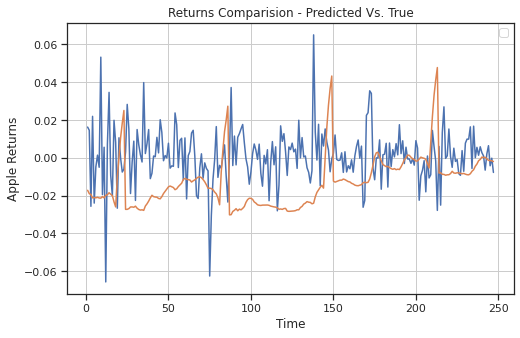

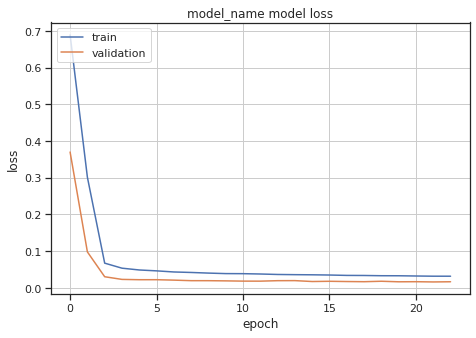

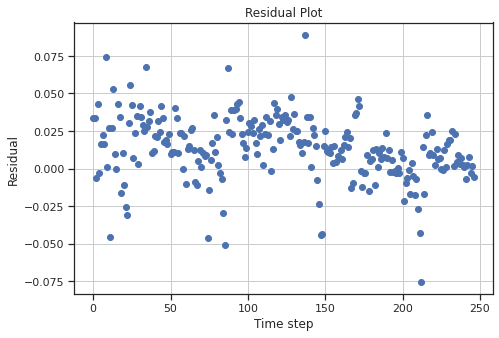

In [ ]:
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error

#callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.05, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

#parameters
max_epochs = 100
model_name = "LSTM_Bidirectional"

model_LSTM_Bi = Sequential()

#adding LSTm layer
model_LSTM_Bi.add(Bidirectional(LSTM(50,return_sequences =True,activation='relu'),input_shape=(X_train.shape[1],X_train.shape[2])))
model_LSTM_Bi.add(Dropout(0.5))
model_LSTM_Bi.add(LSTM(74,return_sequences =False,activation='relu'))
# model_LSTM_v3.add(Dropout(0.2))
# model_LSTM_v3.add(LSTM(74,activation='relu'))
# model_LSTM_v3.add(Dropout(0.2))
#adding Dense
model_LSTM_Bi.add(Dense(1,activation="linear"))

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#compiling
model_LSTM_Bi.compile(loss='mean_absolute_error', optimizer=opt)
model_LSTM_Bi.summary()

#fitting
history_LSTM_Bi = model_LSTM_Bi.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=max_epochs,callbacks=es_callback)

#predictions
y_test_pred = model_LSTM_Bi.predict(X_test)

#evaluating the test data
score = model_LSTM_Bi.evaluate(x=X_test,y=y_test)

#inversescaling
y_test = scaler_var_target.inverse_transform(y_test)
y_test_pred = scaler_var_target.inverse_transform(y_test_pred)

print("-"*50)
print("{n:s}: Test loss from model: {l:5.5f} ".format(n="model_name", l=score))
print("-"*50)
print("Mean Squared error after invers transform : ",mean_squared_error(y_test,y_test_pred))
print("Mean Absolute error after invers transform : ",mean_absolute_error(y_test,y_test_pred))


#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM_Bi,"model_name")
plot_residual(y_test,y_test_pred)


- Looks like the bidirectional model is able to captue some variations in the time series, but the error values are high. 
- We continue to explore more variations of LSTM

## CNN_LSTM
- Here we use CNN_LSTM architechture, with 1 CNN layer followed by max pooling and an LSTM and Dense layer
- Based on my research this structuring should be able to generate better results for time series modelling
- For the input CNN layer we need to split the num_steps into two subsequences

In [ ]:
#getting data
data_AAPL = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
data_AAPL = data_AAPL.iloc[1:,:] #removing first row for NaN values

#Splitting the target and features
y = data_AAPL["AAPL_Return"]
X = data_AAPL.loc[:,"AAPL_Adj_Close":"AAPL_Volume"]
X = X.drop(columns=["AAPL_Div"])
X["yesterday_return"] = X["AAPL_Adj_Close"].pct_change().shift(1)
X = X.iloc[1:,:]

#training data sets
X_train_LSTM_var = X.loc[:"2015-12-31",:]
y_train_LSTM_var = y[:"2015-12-31"]

#testing data sets
X_test_LSTM_var = X.loc["2016-01-01":,:]
y_test_LSTM_var = y.loc["2016-01-01":]

#scaling
scaler_var = MinMaxScaler() #creating a scalar object for features
scaler_var_target = MinMaxScaler() #creating a scalar object for targets

X_train_LSTM_var = scaler_var.fit_transform(X_train_LSTM_var) #fitting and transforming the training data
y_train_LSTM_var = scaler_var_target.fit_transform(y_train_LSTM_var.values.reshape(-1,1)) #transforming the test data set using the same scaler

X_test_LSTM_var = scaler_var.transform(X_test_LSTM_var) #fitting and transforming the training data
y_test_LSTM_var = scaler_var_target.transform(y_test_LSTM_var.values.reshape(-1,1))

n_steps = 10
X_train = []
y_train = []
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_train_LSTM_var)):
    X_train.append(X_train_LSTM_var[i-n_steps:i,:])
    y_train.append(y_train_LSTM_var[i])

for i in range(n_steps,len(X_test_LSTM_var)):
    X_test.append(X_test_LSTM_var[i-n_steps:i,:])
    y_test.append(y_test_LSTM_var[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#reshaping the train data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#reshaing for CNN | here we divide our ten 10 time steps into two subsequences of 5 time steps
X_train = X_train.reshape((X_train.shape[0], 2, 5, X_test.shape[2]))
X_test = X_test.reshape((X_test.shape[0], 2, 5, X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)
print("Dimensions of testing features", X_test.shape)
print("Dimensions of testing target", y_test.shape)

Dimensions of training features (4013, 2, 5, 6)
Dimensions of training target (4013, 1)
Dimensions of testing features (242, 2, 5, 6)
Dimensions of testing target (242, 1)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 2, 5, 64)          448       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 2, 1, 64)          0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 2, 64)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                23000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


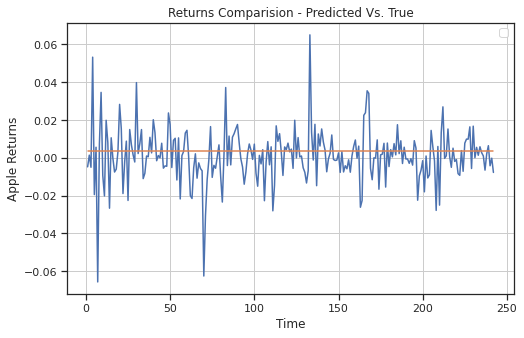

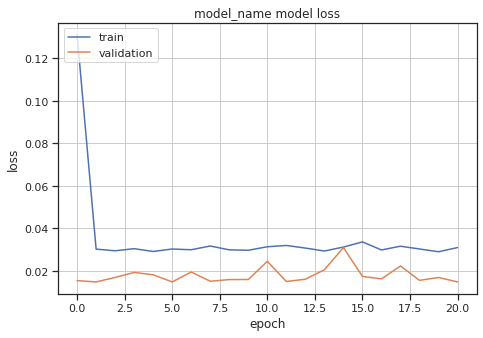

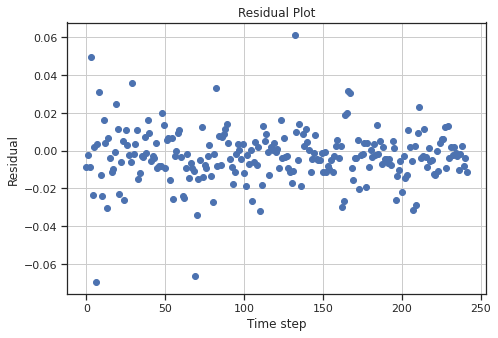

In [ ]:
from tensorflow.keras.layers import Bidirectional, TimeDistributed, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error

#callbacks
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.5, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

#parameters
max_epochs = 500
model_name = "CNN_LSTM"

model_LSTM_CNN = Sequential()

#adding LSTm layer
model_LSTM_CNN.add(TimeDistributed(Conv1D(filters=64,kernel_size=1,activation='relu'),input_shape=(2,5,X_train.shape[3])))
model_LSTM_CNN.add(TimeDistributed(MaxPooling1D(5)))
model_LSTM_CNN.add(TimeDistributed(Flatten()))
model_LSTM_CNN.add(Dropout(0.5))
model_LSTM_CNN.add(LSTM(50,return_sequences =False,activation='relu'))
model_LSTM_CNN.add(Dropout(0.5))

#adding Dense
model_LSTM_CNN.add(Dense(1,activation="linear"))

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

#compiling
model_LSTM_CNN.compile(loss='mean_absolute_error', optimizer=opt)
model_LSTM_CNN.summary()

#fitting
history_LSTM_CNN = model_LSTM_CNN.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=max_epochs,callbacks=es_callback)

#predictions
y_test_pred = model_LSTM_CNN.predict(X_test)

#evaluating the test data
score = model_LSTM_CNN.evaluate(x=X_test,y=y_test)

#inversescaling
y_test = scaler_var_target.inverse_transform(y_test)
y_test_pred = scaler_var_target.inverse_transform(y_test_pred)

print("-"*50)
print("{n:s}: Test loss from model: {l:5.5f} ".format(n="model_name", l=score))
print("-"*50)
print("Mean Squared error after invers transform : ",mean_squared_error(y_test,y_test_pred))
print("Mean Absolute error after invers transform : ",mean_absolute_error(y_test,y_test_pred))


#plotting results
plt.figure(figsize=(8,5))
plt.plot(range(1,len(y_test)+1),y_test)
plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
plt.xlabel("Time")
plt.ylabel("Apple Returns")
plt.title("Returns Comparision - Predicted Vs. True")
plt.legend()
plt.grid()

plotTrain(history_LSTM_CNN,"model_name")
plot_residual(y_test,y_test_pred)


- Looks like adding a CNN layer did not improve our predictions

#Experiment to predict stock prices and stock returns using univariate data set
- So far we used multiple features/time series
- In this section we perform a simple LSTM to check if we can predict stock prices just based on their previous prices
- This experiment is aiming to test if we can identify the patterns in the time series for stock prices

(3420, 1)
(856, 1)


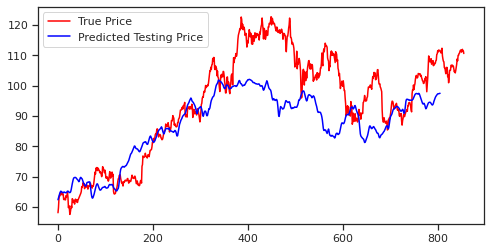

In [ ]:
data_price = data_AAPL["AAPL_Adj_Close"].values
data_price = data_price.reshape(-1,1)

dataset_train = np.array(data_price[:int(data_price.shape[0]*0.8)])
dataset_test = np.array(data_price[int(data_price.shape[0]*0.8):])
print(dataset_train.shape)
print(dataset_test.shape)

#scaling
scaler_open = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler_open.fit_transform(dataset_train)
dataset_test = scaler_open.transform(dataset_test)

#function to fit LSTM
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=50, batch_size=32,verbose=0)

predictions = model.predict(x_test)
predictions = scaler_open.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(data_price[int(data_price.shape[0]*0.8):], color='red',  label="True Price")
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()

- Looks like we are able to track some pattern in the stock price movement
- Let's if a similar approach can work for our returns data

(3420, 1)
(856, 1)


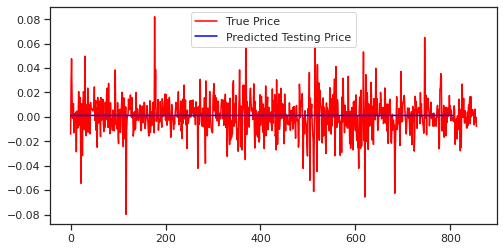

In [ ]:
data_price = data_AAPL["AAPL_Return"].values
data_price = data_price.reshape(-1,1)

dataset_train = np.array(data_price[:int(data_price.shape[0]*0.8)])
dataset_test = np.array(data_price[int(data_price.shape[0]*0.8):])
print(dataset_train.shape)
print(dataset_test.shape)

#scaling
scaler_open = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler_open.fit_transform(dataset_train)
dataset_test = scaler_open.transform(dataset_test)

#function to fit LSTM
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

# Reshape features for LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=100, batch_size=32,verbose=0)

predictions = model.predict(x_test)
predictions = scaler_open.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(data_price[int(data_price.shape[0]*0.8):], color='red',  label="True Price")
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()


- Looks like this model didnt help much for the returns
- One problem might be that the returns data are closely centered at 0, i.e., there is not much variance
- The model is trying to fit a best line, which actually has very decent Mean Squares Error | Mean Absolute error

#Tuning the LSTM Model
- So far we explored different variations of LSTM model to predict the stock returns. But looks like a vanilla model with one LSTM layer seem to be performing better
- Now we will try to tune that model to different batch_sizes, Number of neurons, learning rates, activation functions 
- Tuning these parameters take a lot of time, hence the loops have been converted to comments to avoid running these heavy computations while grading. Please uncomment them if you want to check the runs

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.05, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

## Data preperation
- We will use the same data set for all our experiments for comparability

In [ ]:
#getting data
data_LSTM = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
data_LSTM = data_AAPL.iloc[1:,:] #removing first row for NaN values

#Splitting the target and features
y = data_LSTM["AAPL_Return"]
X = data_LSTM.loc[:,"AAPL_Adj_Close":]
X = X.drop(columns=["AAPL_Div"])

#training data sets
X_train_LSTM = X.loc[:"2015-12-31",:]
y_train_LSTM = y[:"2015-12-31"]

#testing data sets
X_test_LSTM = X.loc["2016-01-01":,:]
y_test_LSTM = y.loc["2016-01-01":]

#printing Dimensions
print("Dimensions of training features", X_train_LSTM.shape)
print("Dimensions of training target", y_train_LSTM.shape)
print("Dimensions of testing features", X_test_LSTM.shape)
print("Dimensions of testing target", y_test_LSTM.shape)

scaler_LSTM = MinMaxScaler() #creating a scalar object
X_train_LSTM = scaler_LSTM.fit_transform(X_train_LSTM) #fitting and transforming the training data

#transforming test data for convinience
X_test_LSTM = scaler.fit_transform(X_test_LSTM) #fitting and transforming the training data

n_steps = 60
X_train = []
y_train = []
X_test = []
y_test = []

#for training data set
for i in range(n_steps,len(X_train_LSTM)):
    X_train.append(X_train_LSTM[i-n_steps:i,:])
    y_train.append(y_train_LSTM[i])

#for testing data set
for i in range(n_steps,len(X_test_LSTM)):
    X_test.append(X_test_LSTM[i-n_steps:i,:])
    y_test.append(y_test_LSTM[i])

#reshaping the train data set
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))

#reshaping the test data set
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

#printing Dimensions
print("Dimensions of training features", X_train.shape)
print("Dimensions of training target", y_train.shape)
print("Dimensions of testing features", X_test.shape)
print("Dimensions of testing target", y_test.shape)



Dimensions of training features (4023, 6)
Dimensions of training target (4023,)
Dimensions of testing features (252, 6)
Dimensions of testing target (252,)
Dimensions of training features (3963, 60, 6)
Dimensions of training target (3963,)
Dimensions of testing features (192, 60, 6)
Dimensions of testing target (192,)


## Batch size iteration (*converted to comments)

In [ ]:
# score_mae_batch = {} #dictionary to store mae values
# score_mse_batch = {} #dictionary to store mse values

# for i in [1,2,4,8,16,32,64]:
#     #parameters
#     max_epochs = 100

#     model_LSTM = Sequential()

#     #adding LSTm layer
#     layer_LSTM = LSTM(60,input_shape=(X_train.shape[1],X_train.shape[2]))
#     model_LSTM.add(layer_LSTM)

#     #adding Dense
#     model_LSTM.add(Dense(1))

#     #optimizer
#     #opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#     #compiling
#     model_LSTM.compile(loss='mean_absolute_error', optimizer="adam")
#     model_LSTM.summary()

#     #fitting
#     history_LSTM = model_LSTM.fit(X_train,y_train,batch_size = i, validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=0)

#     #predictions
#     y_test_pred = model_LSTM.predict(X_test)

#     score_mae_batch.update({i:mean_absolute_error(y_test,y_test_pred)})
#     score_mse_batch.update({i:mean_squared_error(y_test,y_test_pred)})

Model: "sequential_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_358 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_359 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1

## Activation function iteration (*converted to comments)

In [ ]:
# score_mae_activation = {} #dictionary to store mae values
# score_mse_activation = {} #dictionary to store mse values

# for i in ["relu","elu","selu","sigmoid",tf.keras.layers.LeakyReLU(alpha=0.1),"tanh"]:
#     #parameters
#     max_epochs = 100

#     model_LSTM = Sequential()

#     #adding LSTm layer
#     layer_LSTM = LSTM(60,input_shape=(X_train.shape[1],X_train.shape[2]),activation=i)
#     model_LSTM.add(layer_LSTM)

#     #adding Dense
#     model_LSTM.add(Dense(1))

#     #optimizer
#     #opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#     #compiling
#     model_LSTM.compile(loss='mean_absolute_error', optimizer="adam")
#     model_LSTM.summary()

#     #fitting
#     history_LSTM = model_LSTM.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=0)

#     #predictions
#     y_test_pred = model_LSTM.predict(X_test)

#     score_mae_activation.update({i:mean_absolute_error(y_test,y_test_pred)})
#     score_mse_activation.update({i:mean_squared_error(y_test,y_test_pred)})


Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_365 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_366 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_173 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1

## Number of neurons iteration (*converted to comments)

In [ ]:
# score_mae_neurons = {} #dictionary to store mae values
# score_mse_neurons = {} #dictionary to store mse values

# for i in [30,60,90]:
#     #parameters
#     max_epochs = 100

#     model_LSTM = Sequential()

#     #adding LSTm layer
#     layer_LSTM = LSTM(i,input_shape=(X_train.shape[1],X_train.shape[2]),activation="relu")
#     model_LSTM.add(layer_LSTM)

#     #adding Dense
#     model_LSTM.add(Dense(1))

#     #optimizer
#     #opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

#     #compiling
#     model_LSTM.compile(loss='mean_absolute_error', optimizer="adam")
#     model_LSTM.summary()

#     #fitting
#     history_LSTM = model_LSTM.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=0)

#     #predictions
#     y_test_pred = model_LSTM.predict(X_test)

#     score_mae_neurons.update({i:mean_absolute_error(y_test,y_test_pred)})
#     score_mse_neurons.update({i:mean_squared_error(y_test,y_test_pred)})

Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_371 (LSTM)              (None, 30)                4440      
_________________________________________________________________
dense_178 (Dense)            (None, 1)                 31        
Total params: 4,471
Trainable params: 4,471
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_372 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_179 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_191

## Learning rate iteration (*converted to comments)

In [ ]:
# score_mae_alpha = {} #dictionary to store mae values
# score_mse_alpha = {} #dictionary to store mse values

# for i in [0.01,0.001,0.0001]:
#     #parameters
#     max_epochs = 100

#     model_LSTM = Sequential()

#     #adding LSTm layer
#     layer_LSTM = LSTM(60,input_shape=(X_train.shape[1],X_train.shape[2]),activation="relu")
#     model_LSTM.add(layer_LSTM)

#     #adding Dense
#     model_LSTM.add(Dense(1))

#     #optimizer
#     opt = tf.keras.optimizers.Adam(learning_rate=i)

#     #compiling
#     model_LSTM.compile(loss='mean_absolute_error', optimizer="adam")
#     model_LSTM.summary()

#     #fitting
#     history_LSTM = model_LSTM.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=0)

#     #predictions
#     y_test_pred = model_LSTM.predict(X_test)

#     score_mae_alpha.update({i:mean_absolute_error(y_test,y_test_pred)})
#     score_mse_alpha.update({i:mean_squared_error(y_test,y_test_pred)})

Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_374 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_375 (LSTM)              (None, 60)                16080     
_________________________________________________________________
dense_182 (Dense)            (None, 1)                 61        
Total params: 16,141
Trainable params: 16,141
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1

#Tuning Results

In [ ]:
# print("MAE for different batch_sizes : ",score_mae_batch )
# print("MSE for different batch_sizes : ",score_mse_batch )
# print("-"*50)
# print("MAE for different activation functions : ",score_mae_activation )
# print("MSE for different activation functions : ",score_mse_activation )
# print("-"*50)
# print("MAE for different number of neurons : ",score_mae_neurons )
# print("MSE for different number of neurons : ",score_mse_neurons )
# print("-"*50)
# print("MAE for different learning rates : ",score_mae_alpha )
# print("MSE for different learning rates : ",score_mse_alpha )
# print("-"*50)

MAE for different batch_sizes :  {1: 0.011603526226580832, 2: 0.017958875523971095, 4: 0.013565593200930181, 8: 0.011758310310501384, 16: 0.01847683801078322, 32: 0.014616656186974624, 64: 0.013089629222078278}
MSE for different batch_sizes :  {1: 0.000225756959157131, 2: 0.0004573998590800964, 4: 0.00028823979864833386, 8: 0.00024778167802836477, 16: 0.00047556683292774405, 32: 0.00032118274102292855, 64: 0.00031143553837538793}
--------------------------------------------------
MAE for different activation functions :  {'relu': 0.013800536246340535, 'elu': 0.01385090867320369, 'selu': 0.04493095876142756, 'sigmoid': 0.011990603519277146, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f4941066110>: 0.017891207256736586, 'tanh': 0.024521368408642163}
MSE for different activation functions :  {'relu': 0.0003244092459769048, 'elu': 0.0003076135817631633, 'selu': 0.0028161795091933444, 'sigmoid': 0.00025095874299989747, <tensorflow.python.keras.layers.advanced

In [ ]:
# score_mae_batch_pd = pd.DataFrame.from_dict(score_mae_batch,orient='index',columns=["MAE"])
# score_mae_activation_pd = pd.DataFrame.from_dict(score_mae_activation,orient='index',columns=["MAE"])
# score_mae_neurons_pd = pd.DataFrame.from_dict(score_mae_neurons,orient='index',columns=["MAE"])
# score_mae_alpha_pd = pd.DataFrame.from_dict(score_mae_alpha,orient='index',columns=["MAE"])

Text(0.5, 0, 'Batch size')

Text(0, 0.5, 'Mean Absolute Error')

Text(0.5, 1.0, 'MAE comparision for different batch sizes')

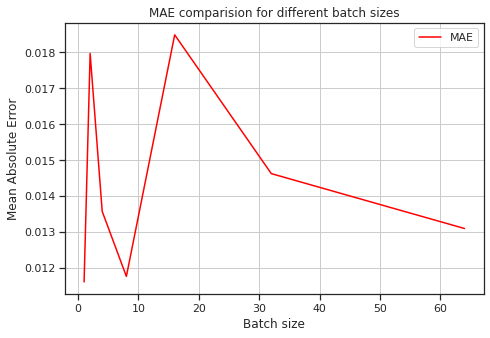

In [ ]:
# #plotting the data frames
# plt.rcParams["figure.figsize"] = (7.5,5)
# score_mae_batch_pd.plot(color="red")
# plt.xlabel("Batch size")
# plt.ylabel("Mean Absolute Error")
# plt.title("MAE comparision for different batch sizes")
# plt.grid()

- Increasing the batch_size helps in convergence as the weights are updated only once per ever batch_size samples
- But looks like having a bacth_size of 1 is beneficial for our problem

Text(0.5, 0, 'Activation functions')

Text(0, 0.5, 'Mean Absolute Error')

Text(0.5, 1.0, 'MAE comparision for different activation functions')

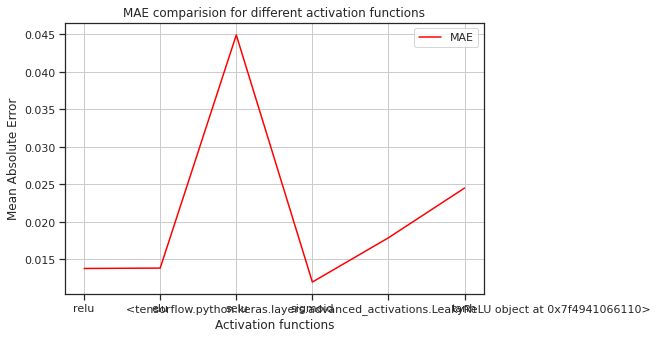

In [ ]:
# plt.rcParams["figure.figsize"] = (7.5,5)
# score_mae_activation_pd.plot(color="red")
# plt.xlabel("Activation functions")
# plt.ylabel("Mean Absolute Error")
# plt.title("MAE comparision for different activation functions")
# plt.grid()

- looks like sigmoid has the lowest MAE, but given the stochastic nature of our optimizer Adam, these values are subject to change a lot
- Considering Relu has a similar score and better range of derivatives, we will continue to use it

Text(0.5, 0, 'Number of neurons')

Text(0, 0.5, 'Mean Absolute Error')

Text(0.5, 1.0, 'MAE comparision for different number of neurons')

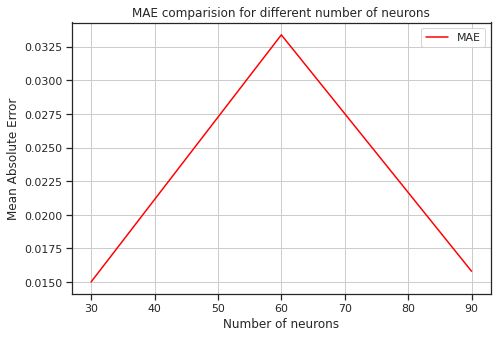

In [ ]:
# plt.rcParams["figure.figsize"] = (7.5,5)
# score_mae_neurons_pd.plot(color="red")
# plt.xlabel("Number of neurons")
# plt.ylabel("Mean Absolute Error")
# plt.title("MAE comparision for different number of neurons")
# plt.grid()

- Looks like 30 neurons are enough to train our model

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Mean Absolute Error')

Text(0.5, 1.0, 'MAE comparision for different learning rate')

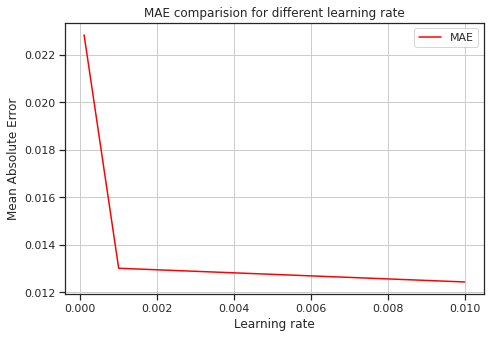

In [ ]:
plt.rcParams["figure.figsize"] = (7.5,5)
score_mae_alpha_pd.plot(color="red")
plt.xlabel("Learning rate")
plt.ylabel("Mean Absolute Error")
plt.title("MAE comparision for different learning rate")
plt.grid()

- Looks like decreasing the learning is helping the model to acheive stability
- We will use 0.001 as the learning rate in our best model

#Best Model

Model: "sequential_195"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_377 (LSTM)              (None, 90)                34920     
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 91        
Total params: 35,011
Trainable params: 35,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
124/124 [==============================] - 11s 81ms/step - loss: 0.0216 - val_loss: 0.0103
Epoch 2/100
124/124 [==============================] - 10s 83ms/step - loss: 0.0192 - val_loss: 0.0108
Epoch 3/100
124/124 [==============================] - 10s 81ms/step - loss: 0.0197 - val_loss: 0.0152
Epoch 4/100
124/124 [==============================] - 10s 82ms/step - loss: 0.0186 - val_loss: 0.0209
Epoch 5/100
124/124 [==============================] - 10s 79ms/step - loss: 0.0189 - val_loss: 0.

<Figure size 576x360 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Apple Returns')

Text(0.5, 1.0, 'Returns Comparision - Predicted Vs. True')

No handles with labels found to put in legend.


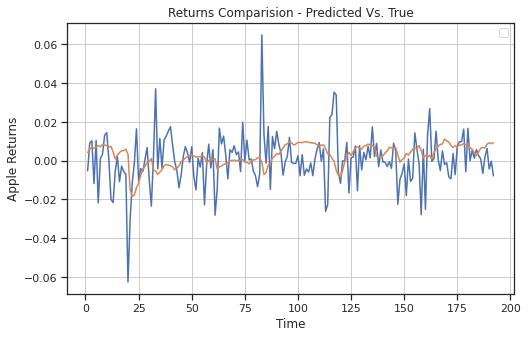

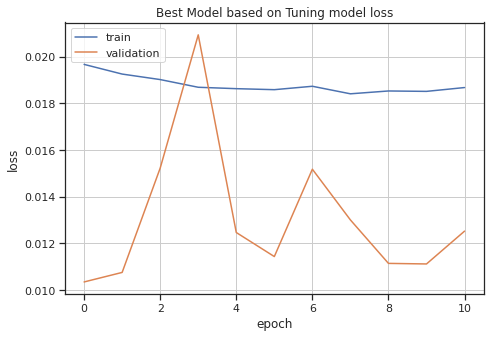

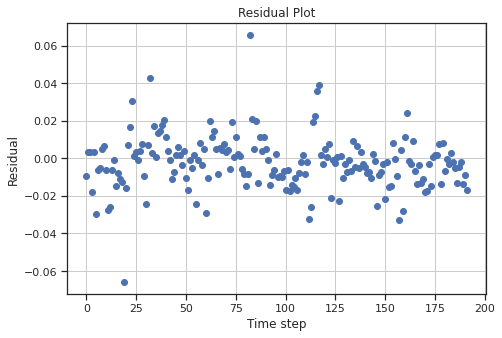

In [ ]:
# #parameters
# max_epochs = 100
# number_neurons = 90 #using to give the model a better change
# activation = "relu"
# alpha = 0.001 #decreasing learning rate for better stability

# model_LSTM_best = Sequential()

# #adding LSTm layer
# layer_LSTM = LSTM(number_neurons,input_shape=(X_train.shape[1],X_train.shape[2]),activation="relu")
# model_LSTM_best.add(layer_LSTM)

# #adding Dense
# model_LSTM_best.add(Dense(1))

# #optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=alpha)

# #compiling
# model_LSTM_best.compile(loss='mean_absolute_error', optimizer="adam")
# model_LSTM_best.summary()

# #fitting
# history_LSTM_best = model_LSTM_best.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=100,callbacks=es_callback,verbose=1)

# #predictions
# y_test_pred = model_LSTM_best.predict(X_test)

# print("Mean Squared error : ",mean_squared_error(y_test,y_test_pred))
# print("Mean Absolute error : ",mean_absolute_error(y_test,y_test_pred))

# #plotting results
# plt.figure(figsize=(8,5))
# plt.plot(range(1,len(y_test)+1),y_test)
# plt.plot(range(1,len(y_test_pred)+1),y_test_pred)
# plt.xlabel("Time")
# plt.ylabel("Apple Returns")
# plt.title("Returns Comparision - Predicted Vs. True")
# plt.legend()
# plt.grid()

# plotTrain(history_LSTM_best,"Best Model based on Tuning")
# plot_residual(y_test,y_test_pred)



- This model has definetely produced a better MAE
- Given our validation loss is lower than the training loss, we can conclude that the model is not overfitting

#Goal and Conclusion
**Background** : Predicting the stock market returns is a very useful process in trading. In this project we aim to predict the 1-day future returns of apple stock. We could also model this problem as a classifciation to predict Up/Down movements. But this would not particularly help, as we don't the maginitude of the movement. Due to this our trading strategy might end up in losses if the profit made from using the model is less than the transaction costs

**Goal** : Predict the next day return of AAPL stock

**Methodology** :
- First we start with loading all the data sets available and perform EDA on different features to get a sense of the data
- We use XGboost regressor for identifying the important features
- Later we use RNN networks (predominatly LSTM) given its ability to identify historical dependencies to solve our problem
- Training the model is performed throgh an iterative process by considering feedback from the error analysis

**Conclusion** :
- The stochastic nature of the stock returns makes this problem difficult
- Our models were able to reduce the Mean Absolute Error but they tried capture the variations (peaks) in the returns
- In our multiple experiments, we notice that a vanilla single layer LSTM works the best
- Adding additional features was found to be detrimental to our cause, suggesting the complex relationship of returns with other variables
- In order to make this model better, we need to continue to tune our model parameters. Num of time steps iteration was not done in this project due to the time complexity, but performing such an analysis might give us more insight
- An encoder/decoder framework might yield better results. But this has to be still tested
- Based on our analysis, we can conclude that possible hypothesis for our perfomance - *The change in price are generally small for 1 day, that makes change in returns even smaller. Due to this our model tends to approximate the returns with a relatively flat line centered at 0*

#Storing the Model

In [ ]:
saveModel(model_LSTM_best, "./model_path_say294")

Directory ./model_path_say294 already exists, files will be over-written.
Model saved in directory ./model_path_say294; create an archive of this directory and submit with your assignment.


In [ ]:
#saving the scaler
from sklearn.externals import joblib
scaler_filename = "scaler_best.save"
joblib.dump(scaler_LSTM, scaler_filename) 


['scaler_best.save']

In [ ]:
#saving the model
def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))

In [ ]:
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

In [ ]:
def MyModel(test_dir, model_path):

    from sklearn.externals import joblib
    import os

    #changing to test directory
    os.chdir(test_dir)

    #data preperation
    tickers = ["AAPL"]
    dateAttr = "Dt" #index column
    priceAttr = ["Dt","Adj Close","Div","Volume","High","Low","Open"]



    # Read the CSV files
    data_master = []
    for ticker_num, ticker in enumerate(tickers):
        ticker_file = os.path.join("./data/holdout", "{t}.csv".format(t=ticker) )
        ticker_df = pd.read_csv(ticker_file,index_col=0,usecols=priceAttr) 
        # Rename attributes with ticker name
        ticker_df["Return"]  = ticker_df["Adj Close"].pct_change() 
        rename_map = { orig:  ticker + "_" + orig.replace(" ", "_") for orig in ticker_df.columns.to_list() }     
        ticker_df= ticker_df.rename(columns=rename_map) 
        data_master.append(ticker_df)     
    data_master = pd.concat(data_master,axis=1)

    #getting data
    data_LSTM = data_master.loc[:,"AAPL_Adj_Close":"AAPL_Return"]
    data_LSTM = data_AAPL.iloc[1:,:] #removing first row for NaN values

    #Splitting the target and features
    y = data_AAPL["AAPL_Return"]
    X = data_AAPL.loc[:,"AAPL_Adj_Close":]
    X = X.drop(columns=["AAPL_Div"])
    index = X.index[60:] #storing dates | indexing with 60 as we are using 60 time steps
    scaler_LSTM = joblib.load(scaler_filename)  #creating a scalar object
    X_train_LSTM = scaler_LSTM.transform(X) #fitting and transforming the training data

    n_steps = 60
    X_test = []
    y_test = []

    #for testing data set
    for i in range(n_steps,len(X_train_LSTM)):
        X_test.append(X_train_LSTM[i-n_steps:i,:])
        y_test.append(y[i])

    #reshaping the test data set
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2]))

    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    predictions = model.predict(X_test)

    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    ids = index
    
    # YOUR CODE GOES HERE
    print("Dimension of Index : ",ids.shape)
    print("Dimension of predictions : ",predictions.shape)
    
    return predictions, ids

# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = None # CHANGE None to your model !



- In the below cell we are testing MyModel function
- We are using the test directory to change it to current directory
- The model uses the saved scaler transformation file and the model file 
- The data is store in a folder called data/holdout

In [ ]:
MyModel("/content/gdrive/MyDrive/stock_prediction","./model_path_say294")

Dimension of Index :  (4216,)
Dimension of predictions :  (4216, 1)


(array([[-0.00119862],
        [ 0.00297701],
        [-0.00302273],
        ...,
        [-0.00146315],
        [-0.00115763],
        [-0.00132578]], dtype=float32),
 Index(['2000-03-30', '2000-03-31', '2000-04-03', '2000-04-04', '2000-04-05',
        '2000-04-06', '2000-04-07', '2000-04-10', '2000-04-11', '2000-04-12',
        ...
        '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
        '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
       dtype='object', name='Dt', length=4216))

In [ ]:
print("Done")

Done
